# Curation of 9 public human scRNAseq data of pancreatic islets

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import bbknn

In [2]:
sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.8 umap==0.4.5 numpy==1.21.2 scipy==1.5.4 pandas==1.3.5 scikit-learn==0.22 statsmodels==0.13.2 python-igraph==0.8.0 louvain==0.7.0 leidenalg==0.7.0


In [3]:
sc.set_figure_params(frameon=False, dpi_save=300, color_map='Reds')

## Xin et al.

### Load and preprocess

Data downloaded from: [GSE114297](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE114297)

In [9]:
import os
path = './data/Xin_GSE114297_RAW/'
ixs = os.listdir(path)

In [10]:
ixs = sorted(list(set([ix.rsplit('_',1)[0] for ix in ixs])))

In [ ]:
adatas = []
for ix in ixs:
    adata = sc.read_mtx(f'{path}{ix}_matrix.mtx.gz').T
    adata.obs_names = pd.read_csv(f'{path}{ix}_barcodes.tsv.gz', sep='\t', header=None)[0].tolist()
    adata.var_names = pd.read_csv(f'{path}{ix}_genes.tsv.gz', sep='\t', header=None)[0].tolist()
    adata.var_names_make_unique()
    adatas.append(adata)

In [8]:
xin = adatas[0].concatenate(adatas[1:])

In [28]:
xin.obs['geo_sample'] = [ixs[int(x)].split('_')[0] for x in xin.obs['batch'].values]
xin.obs['donor'] = ['donor_'+str(int(x)+1) for x in xin.obs.batch]

In [29]:
meta = pd.read_csv('./data/Xin_GSE114297_series_matrix.txt', sep='\t', index_col=0).T

In [30]:
meta.columns = ['donor', 'ethnicity', 'sex']

In [40]:
xin.obs['ethnicity'] = meta.loc[xin.obs.geo_sample]['ethnicity'].tolist()
xin.obs['sex'] = meta.loc[xin.obs.geo_sample]['sex'].tolist()

In [48]:
meta_s1 = pd.read_excel('./data/Xin_db180365supplementarytables1.xlsx')

In [50]:
meta_s1.index = ['donor_' + x.split('-')[1] for x in meta_s1['Donor ID']]

In [57]:
xin.obs['age'] = meta_s1.loc[xin.obs.donor]['Age'].tolist()
xin.obs['bmi'] = meta_s1.loc[xin.obs.donor]['BMI'].tolist()
xin.obs['weight[lbs]'] = meta_s1.loc[xin.obs.donor]['Weight (lbs)'].tolist()
xin.obs['height'] = meta_s1.loc[xin.obs.donor]['Height'].tolist()
xin.obs['HbA1c'] = meta_s1.loc[xin.obs.donor]['HbA1c '].tolist()
xin.obs['cause_of_death'] = meta_s1.loc[xin.obs.donor]['Cause of Death'].tolist()

In [97]:
xin.obs['sex'] = xin.obs['sex'].str.lower()

In [99]:
xin.obs['condition'] = 'healthy'
xin.obs['study'] = 'Xin et al, 2018'

In [9]:
sc.pp.filter_cells(xin, min_counts=200)
sc.pp.filter_cells(xin, min_genes=200)

filtered out 6 cells that have less than 200 genes expressed


In [10]:
#remove genes not seen in 10 cells
sc.pp.filter_genes(xin, min_cells=10)

filtered out 11617 genes that are detected in less than 10 cells


In [11]:
sc.pp.normalize_total(xin, exclude_highly_expressed=True)
sc.pp.log1p(xin)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['RBP4', 'MMP7', 'INS', 'FTH1', 'MALAT1', 'IAPP', 'SERPINA1', 'SERPINA3', 'B2M', 'MT1G', 'CTRB2', 'CTRB1', 'PPY', 'TTR', 'FTL', 'CHGB', 'GCG', 'REG1B', 'REG1A', 'REG3A', 'GHRL', 'SST', 'IGFBP7', 'SPP1', 'SPINK1', 'VIP', 'CLPS', 'PRSS1', 'PRSS3P2', 'HSPA5', 'ENSG00000198886', 'ENSG00000198727', 'ENSG00000210082', 'ENSG00000198763', 'ENSG00000198804', 'ENSG00000198712', 'ENSG00000198938', 'TMSB4X', 'TIMP1']
    finished (0:00:00)


### Manifold and clustering

In [13]:
sc.pp.highly_variable_genes(xin, n_top_genes=2000)
sc.pp.pca(xin)
sc.pp.neighbors(xin)
sc.tl.umap(xin)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50


/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


In [14]:
sc.tl.louvain(xin)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 22 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:04)


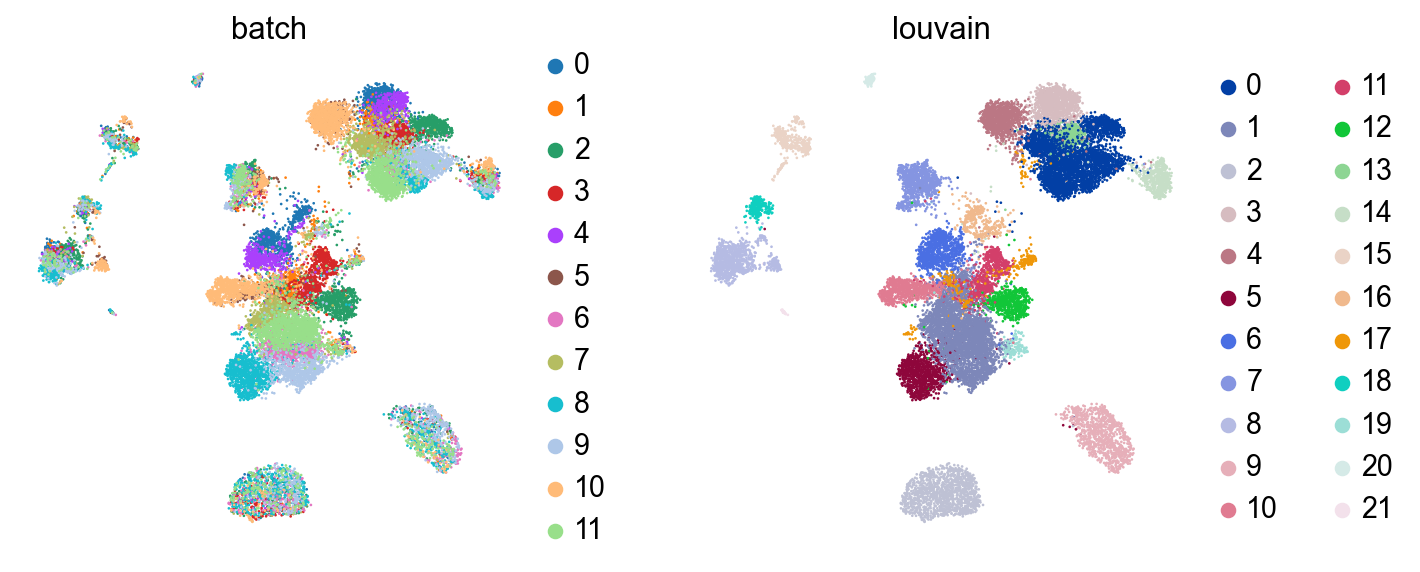

In [15]:
sc.pl.umap(xin, color=['batch', 'louvain'])

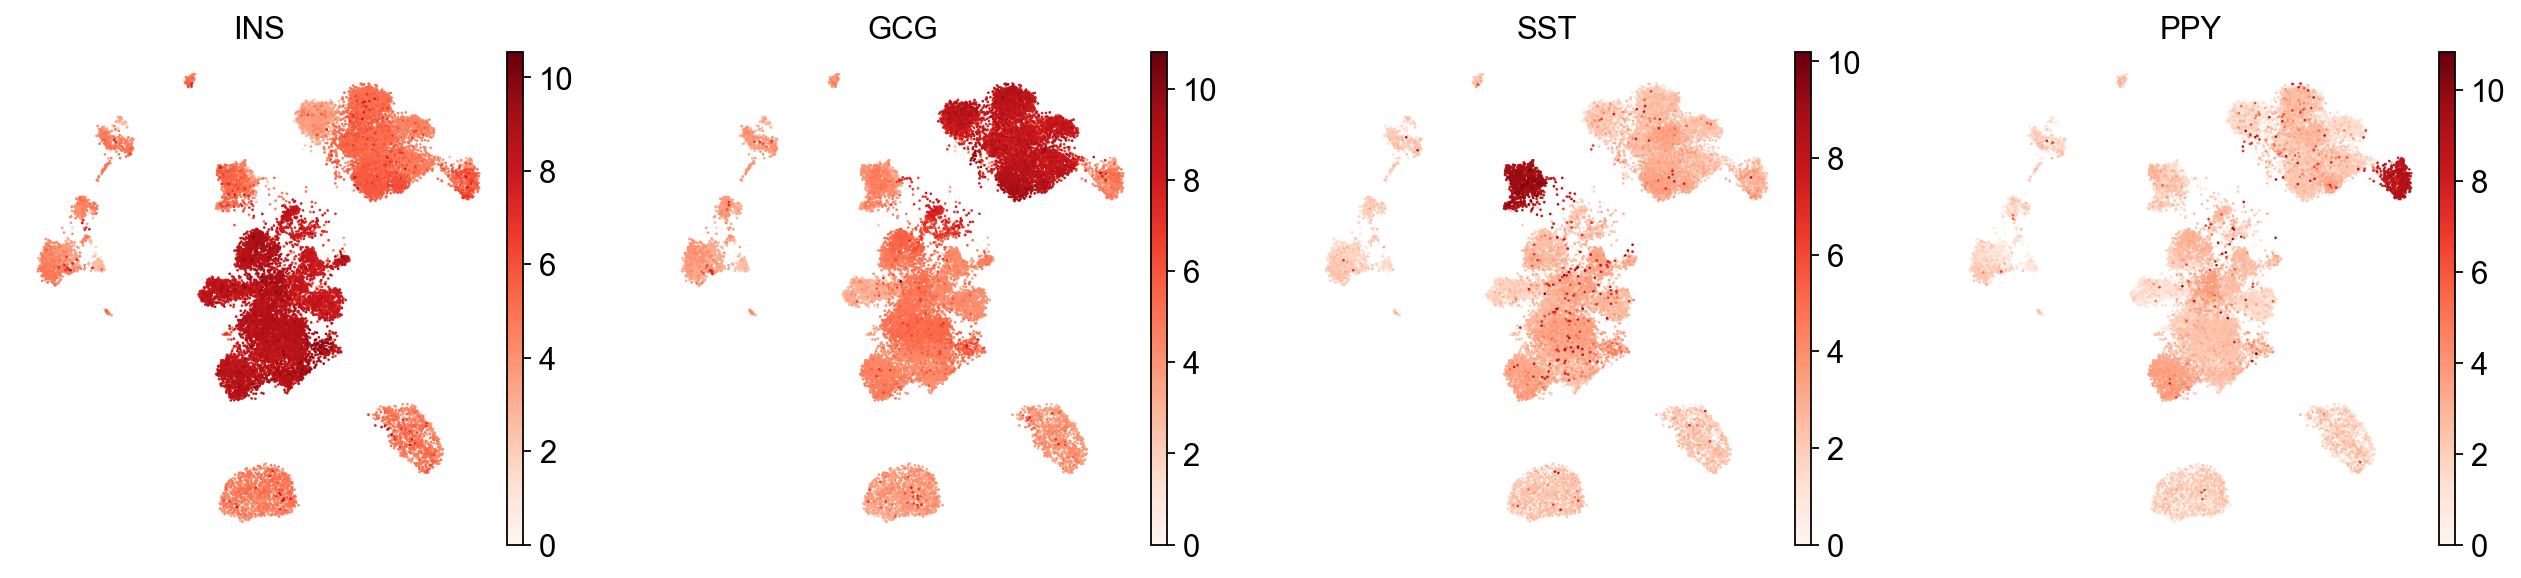

In [16]:
sc.pl.umap(xin, color=['INS', 'GCG', 'SST', 'PPY'])

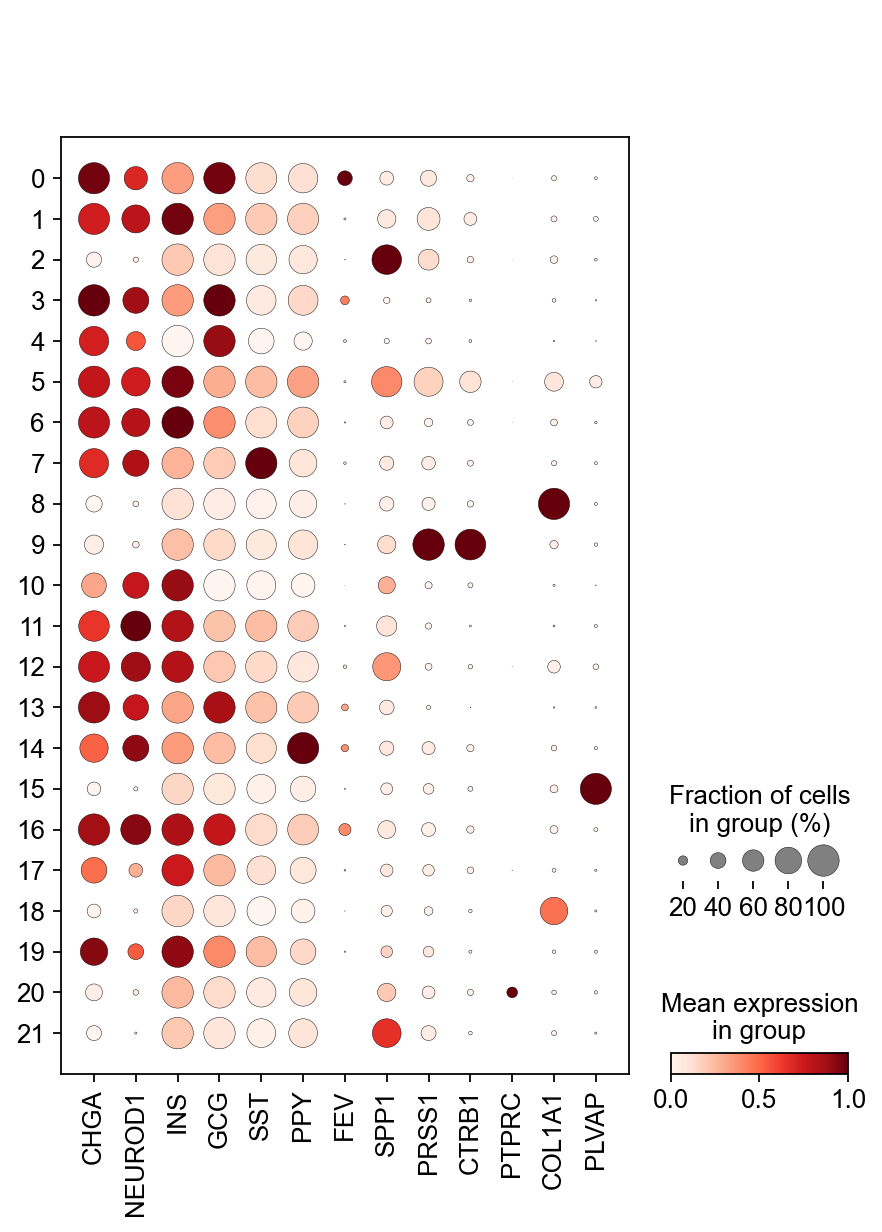

In [17]:
sc.pl.dotplot(xin, groupby='louvain', 
              var_names=['CHGA', 'NEUROD1', 'INS', 'GCG', 'SST', 'PPY', 'FEV', 'SPP1', 'PRSS1', 'CTRB1', 'PTPRC', 'COL1A1', 'PLVAP'], 
              standard_scale='var')

In [20]:
map_names = {}

for c in xin.obs['louvain'].cat.categories:
    if c in ['1', '5','6', '10', '11', '12', '17', '19']:
        map_names[c] = 'beta'
    elif c in ['0', '3', '4', '13']:
        map_names[c] = 'alpha'  
    elif c in ['7']:
        map_names[c] = 'delta'
    elif c in ['14']:
        map_names[c] = 'PP'    
    elif c in ['16']:
        map_names[c] = 'polyhormonal'
    elif c in ['21', '2']:
        map_names[c] = 'ductal' 
    elif c in ['9']:
        map_names[c] = 'acinar' 
    elif c in ['15']:
        map_names[c] = 'endothelial'
    elif c in ['8', '18']:
        map_names[c] = 'stellate/fibroblast'
    elif c in ['20']:
        map_names[c] = 'immune' 
    else:
        map_names[c] = c

xin.obs['louvain_anno_broad'] = xin.obs['louvain']
xin.obs['louvain_anno_broad'] = xin.obs['louvain_anno_broad'].map(map_names).astype('category')

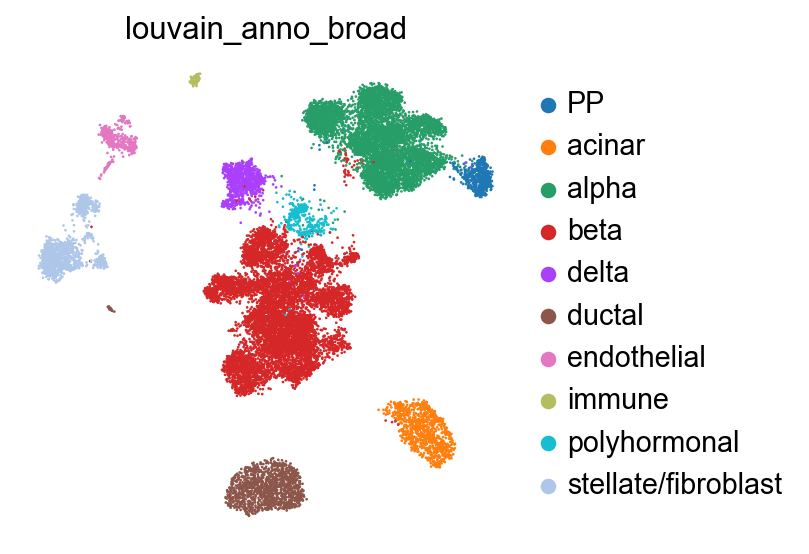

In [21]:
sc.pl.umap(xin, color=['louvain_anno_broad'])

In [100]:
xin.X = csr_matrix(xin.X)
xin.write('./data/xin.h5ad')

/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sex' as categorical
/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'condition' as categorical
/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a

## Segerstolpe et al.

Data downloaded from [E-MTAB-5061](https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-5061/)

In [46]:
df = pd.read_csv('./data/Segerstolpe_data/pancreas_refseq_rpkms_counts_3514sc.txt', sep='\t', skiprows=1, header=None)

In [47]:
df.shape

(26271, 7030)

In [48]:
# use rpkm values
df_proc = df.loc[:,2:3515]

In [49]:
# remove 92 ERCCs and eGFP
df[0][26170:26180]

26170                     KIR2DL5B
26171                      KIR2DS2
26172                      KIR2DS1
26173                      KIR2DL2
26174                      KIR2DL4
26175                      KIR2DS3
26176                      KIR2DS2
26177                   BIVM-ERCC5
26178    ERCC_30000:mix1_7500:mix2
26179     ERCC_7500:mix1_1875:mix2
Name: 0, dtype: object

In [50]:
df_proc = df_proc[0:26177]

In [51]:
sample_id = pd.read_csv('./data/Segerstolpe_data/pancreas_refseq_rpkms_counts_3514sc.txt', sep='\t', nrows=1, header=None).unstack().tolist()

In [52]:
len(sample_id)

3515

In [53]:
segerstolpe = sc.AnnData(df_proc.T)

/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [54]:
segerstolpe.obs_names = sample_id[1:]

In [55]:
segerstolpe.var_names = df[0][0:26177].tolist()

In [56]:
meta = pd.read_csv('./data/Segerstolpe_data/E-MTAB-5061.sdrf.txt', sep='\t')

In [57]:
meta.shape

(3514, 39)

In [59]:
meta.set_index('Source Name', inplace=True)

In [60]:
meta = meta.loc[segerstolpe.obs_names]

In [61]:
segerstolpe.obs = meta[['Characteristics[single cell well quality]', 'Characteristics[individual]', 'Characteristics[cell type]', 
                        'Characteristics[sex]', 'Characteristics[age]', 'Factor Value[disease]']]

In [62]:
segerstolpe.X = csr_matrix(segerstolpe.X)

In [63]:
# filter not annotated cells
segerstolpe = segerstolpe[segerstolpe.obs['Characteristics[single cell well quality]'].isin(['OK'])].copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [64]:
segerstolpe.obs.columns = ['QC', 'donor', 'celltype', 'sex', 'age', 'condition']

In [104]:
segerstolpe.obs['condition'] = segerstolpe.obs['condition'].tolist()
segerstolpe.obs['condition'].replace({
    'normal': 'healthy',
    'type II diabetes mellitus': 'T2D'
}, inplace=True)

In [65]:
segerstolpe.var_names_make_unique()

### Manifold and clustering

In [66]:
sc.pp.filter_genes(segerstolpe, min_cells=10)

filtered out 7287 genes that are detected in less than 10 cells


In [67]:
# rpkm values...
sc.pp.filter_cells(segerstolpe, min_genes=1)
sc.pp.filter_cells(segerstolpe, min_counts=1)

In [68]:
#sc.pp.normalize_total(segerstolpe, exclude_highly_expressed=True)
sc.pp.log1p(segerstolpe)

In [69]:
sc.pp.highly_variable_genes(segerstolpe, n_top_genes=2000)
sc.pp.pca(segerstolpe)
sc.pp.neighbors(segerstolpe)
sc.tl.umap(segerstolpe)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


In [76]:
sc.tl.louvain(segerstolpe, resolution=1.5)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 21 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


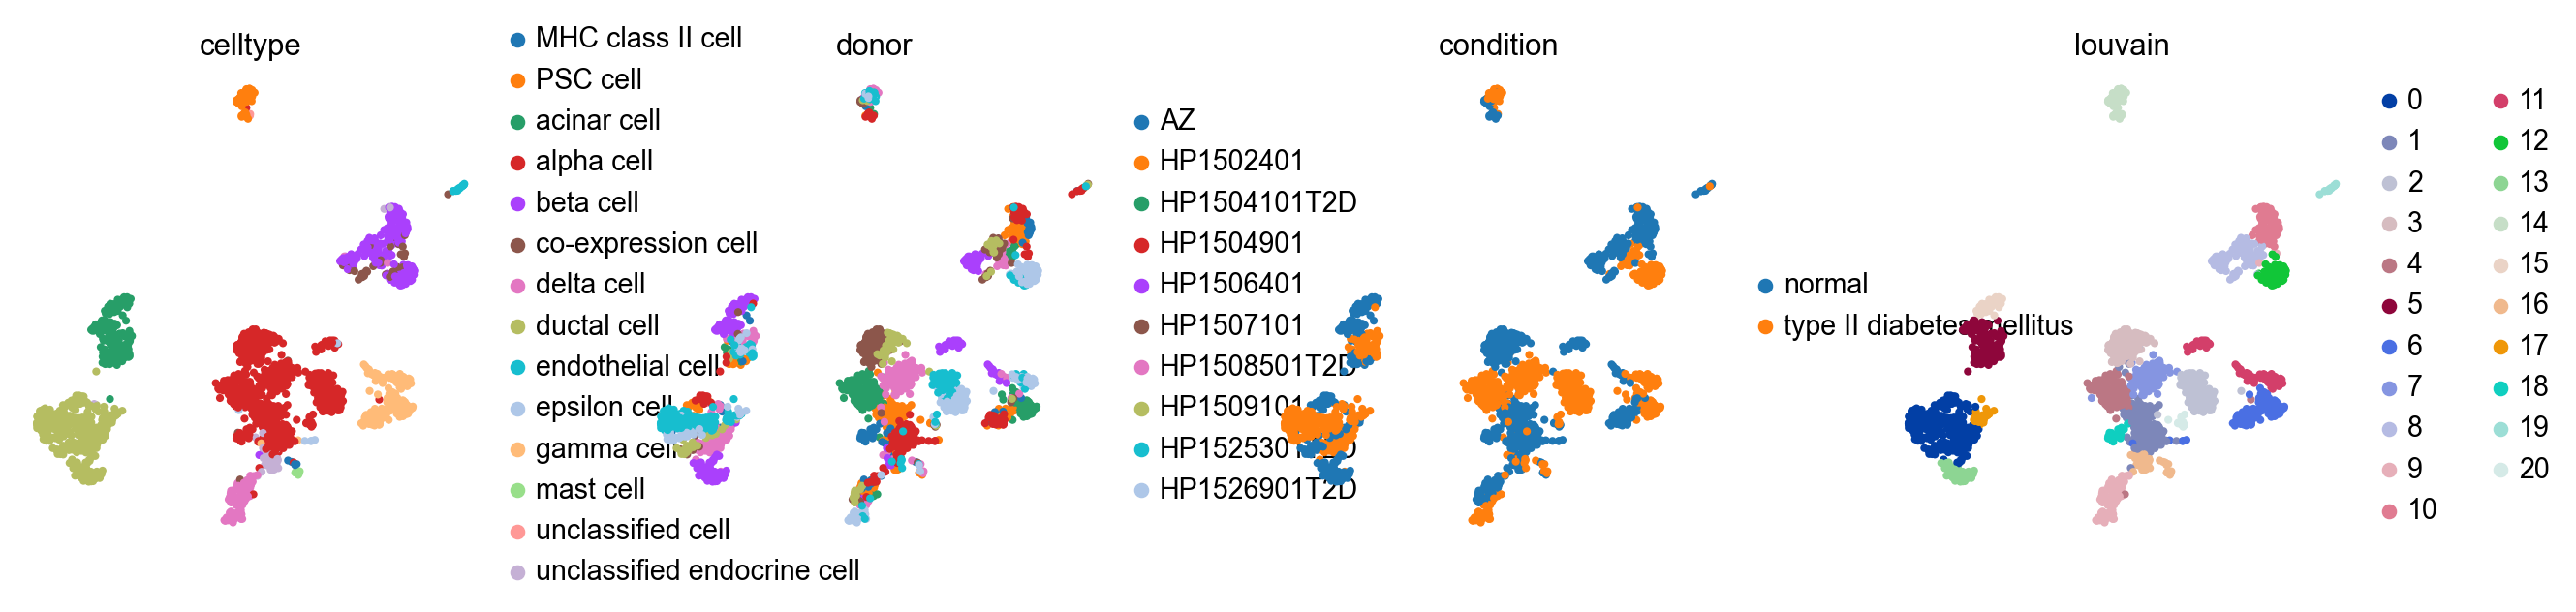

In [77]:
sc.pl.umap(segerstolpe, color=['celltype', 'donor', 'condition', 'louvain'])

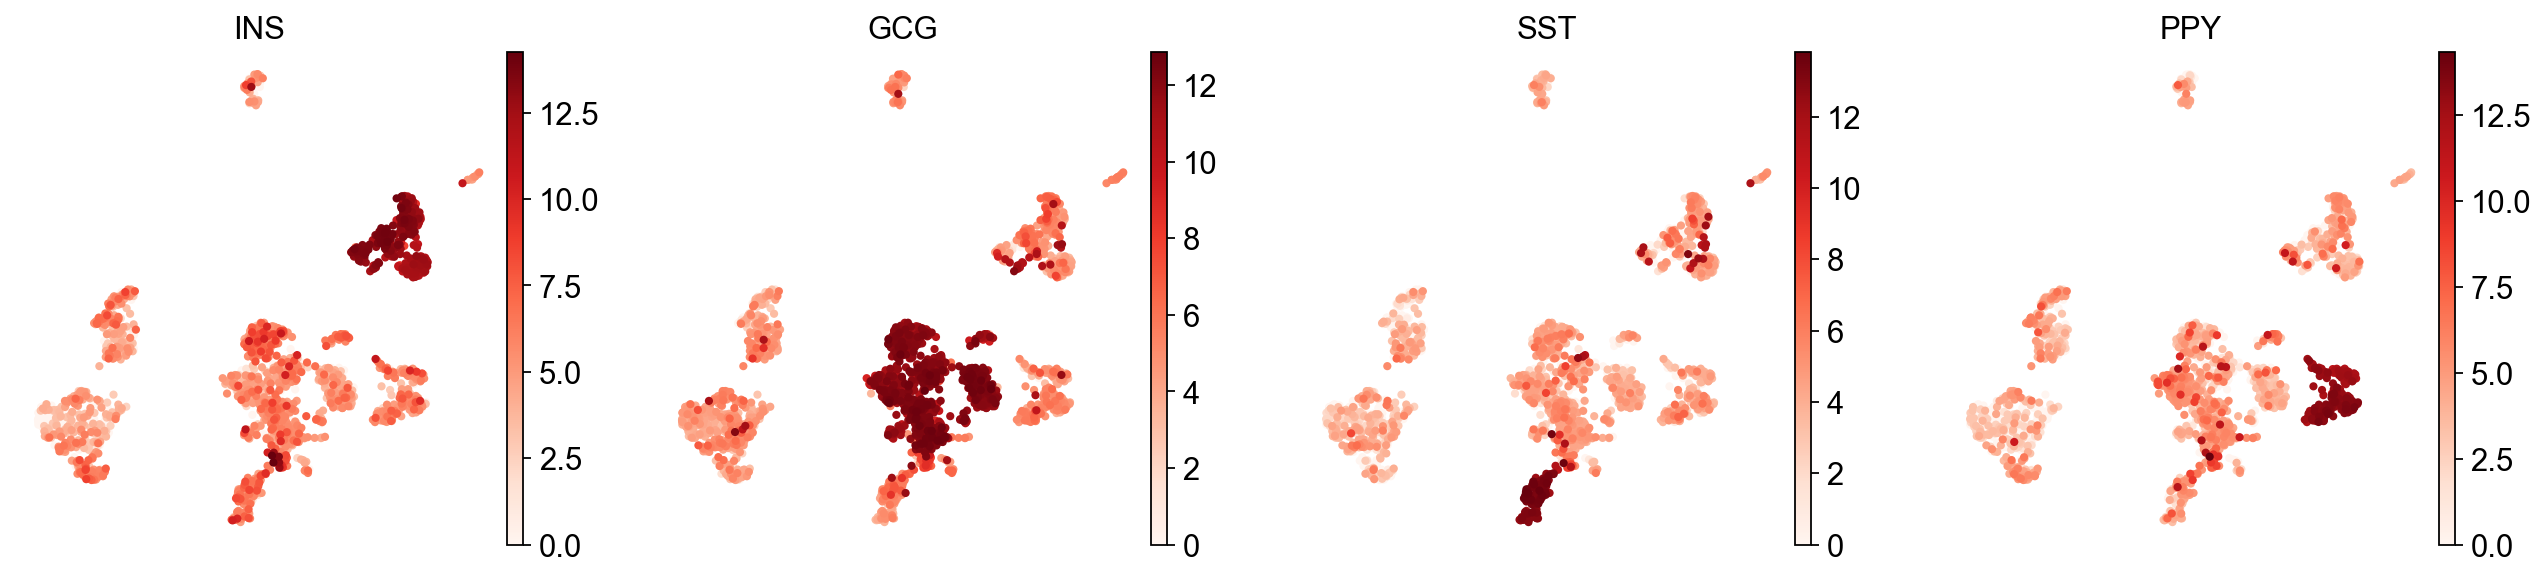

In [78]:
sc.pl.umap(segerstolpe, color=['INS', 'GCG', 'SST', 'PPY'])

In [71]:
segerstolpe.obs.celltype.value_counts()

alpha cell                     886
ductal cell                    386
beta cell                      270
gamma cell                     197
acinar cell                    185
delta cell                     114
PSC cell                        54
unclassified endocrine cell     41
co-expression cell              39
endothelial cell                16
epsilon cell                     7
mast cell                        7
MHC class II cell                5
unclassified cell                2
Name: celltype, dtype: int64

In [135]:
segerstolpe.obs['study'] = 'Segerstolpe et al, 2016'

In [139]:
segerstolpe.obs['louvain_anno_broad'] = segerstolpe.obs['celltype'].copy().tolist()

In [146]:
segerstolpe.obs['louvain_anno_broad'].replace({
    'alpha cell': 'alpha',
    'beta cell': 'beta',
    'delta cell': 'delta',
    'gamma cell': 'PP'
}, inplace=True)

In [148]:
segerstolpe.write('./data/segerstolpe.h5ad')

## Baron et al.

Data downloaded from: [GSE84133](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE84133)

In [79]:
adatas = []
path = './data/Baron_data/'
for smp in ['GSM2230757_human1_umifm_counts.csv.gz', 
            'GSM2230758_human2_umifm_counts.csv.gz', 
            'GSM2230759_human3_umifm_counts.csv.gz',
            'GSM2230760_human4_umifm_counts.csv.gz'
           ]:
    df = pd.read_csv(f'{path}/{smp}')
    adata = sc.AnnData(df.drop(columns=['Unnamed: 0', 'barcode', 'assigned_cluster']))
    adata.obs_names = df['Unnamed: 0']
    adata.obs['cluster'] = df['assigned_cluster'].values
    adata.var_names_make_unique()
    adatas.append(adata)

/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [87]:
baron = adatas[0].concatenate(adatas[1:])

In [63]:
baron = sc.read('./data/baron.h5ad')

In [73]:
meta = pd.read_csv('./data/Baron_GSE84133-GPL16791_series_matrix.txt', sep='\t', index_col=0).T

In [75]:
meta.set_index('geo_accession', inplace=True)

In [77]:
meta.columns = ['age', 'sex', 'bmi', 'condition']

In [78]:
meta

age     sex   bmi condition
geo_accession                            
GSM2230757     17    male  21.5        No
GSM2230758     51  female  21.1        No
GSM2230759     38    male  27.5        No
GSM2230760     59  female  29.9       Yes

In [69]:
baron.obs['geo_sample'] = baron.obs['batch'].copy().tolist()
baron.obs['geo_sample'].replace({
    '0': 'GSM2230757',
    '1': 'GSM2230758',
    '2': 'GSM2230759',
    '3': 'GSM2230760'
}, inplace=True)

In [80]:
baron.obs['age'] = meta.loc[baron.obs.geo_sample]['age'].tolist()
baron.obs['sex'] = meta.loc[baron.obs.geo_sample]['sex'].tolist()
baron.obs['bmi'] = meta.loc[baron.obs.geo_sample]['bmi'].tolist()
baron.obs['condition'] = meta.loc[baron.obs.geo_sample]['condition'].tolist()

In [109]:
baron.obs['condition'] = baron.obs['condition'].tolist()
baron.obs['condition'].replace({
    'No': 'healthy',
    'Yes': 'T2D',
}, inplace=True)

In [88]:
sc.pp.filter_genes(baron, min_cells=10)

filtered out 5008 genes that are detected in less than 10 cells


In [89]:
sc.pp.filter_cells(baron, min_genes=200)
sc.pp.filter_cells(baron, min_counts=200)

In [90]:
sc.pp.normalize_total(baron, exclude_highly_expressed=True)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['ACTG1', 'ADCYAP1', 'CELA3A', 'CHGA', 'COL1A1', 'CPA1', 'CPB1', 'CTRB1', 'CTRB2', 'CXCL8', 'FN1', 'FTH1', 'FTL', 'GAPDH', 'GCG', 'GDF15', 'GHRL', 'HSPA5', 'HSPB1', 'IAPP', 'IER3', 'INS', 'MMP9', 'MT2A', 'OLFM4', 'PPY', 'PRSS1', 'PRSS2', 'REG1A', 'REG1B', 'REG3A', 'S100A6', 'SERPINA1', 'SERPINA3', 'SPP1', 'SST', 'TIMP1', 'TTR']
    finished (0:00:01)


In [91]:
sc.pp.log1p(baron)

In [92]:
sc.pp.highly_variable_genes(baron, n_top_genes=2000)
sc.pp.pca(baron)
sc.pp.neighbors(baron)
sc.tl.umap(baron)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)


/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cluster' as categorical


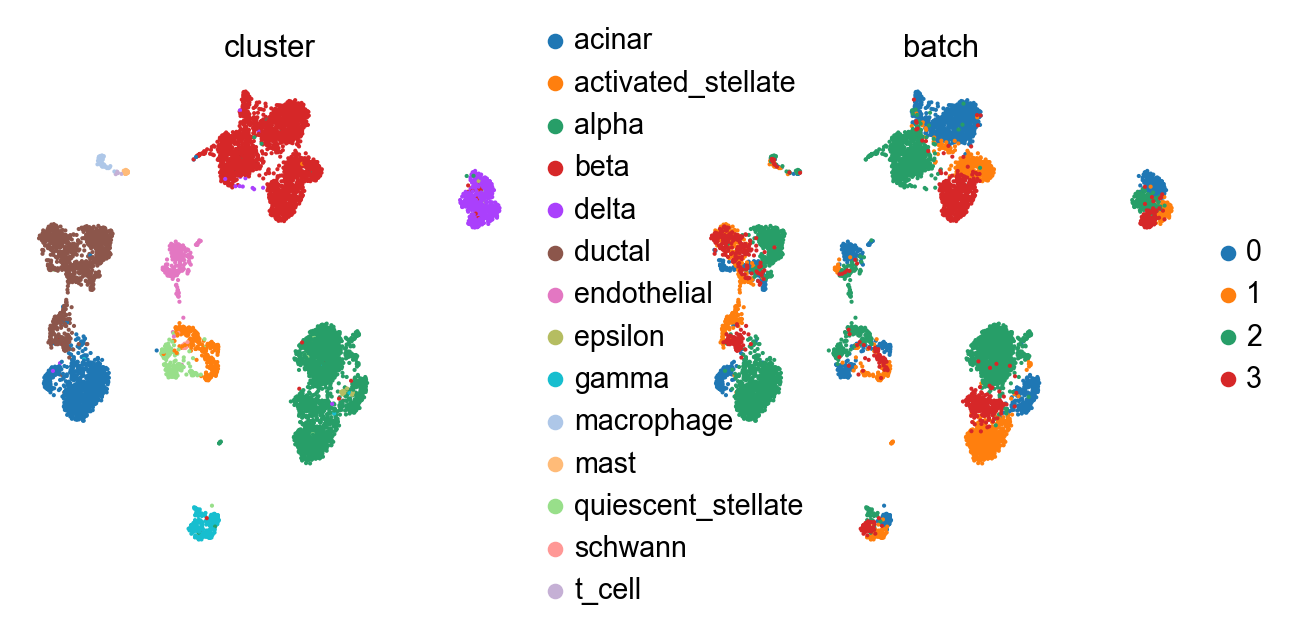

In [93]:
sc.pl.umap(baron, color=['cluster', 'batch'])

In [132]:
baron.obs['study'] = 'Baron et al, 2016'

In [149]:
baron.obs['donor'] = baron.obs['geo_sample'].copy()

In [142]:
baron.obs['louvain_anno_broad'] = baron.obs['cluster'].copy().tolist()

In [144]:
baron.obs['louvain_anno_broad'].replace({'gamma': 'PP'}, inplace=True)

In [150]:
baron.X = csr_matrix(baron.X)
baron.write('./data/baron.h5ad')

## Lawlor et al.

### Load and preprocess

Data downloaded from: [GSE86469](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE86469)

In [110]:
df = pd.read_csv('./data/GSE86469_GEO.islet.single.cell.processed.data.RSEM.raw.expected.counts_Lawlor.csv.gz', index_col=0).T

In [111]:
lawlor = sc.AnnData(df)

In [112]:
meta = pd.read_csv('./data/GSE86469_series_matrix.txt', sep='\t', index_col=0)

In [113]:
lawlor.obs = meta.T.loc[lawlor.obs_names]

In [114]:
lawlor.obs.columns = ['sex', 'disease', 'age', 'race', 'BMI', 'islet_unos_id']

In [115]:
lawlor.obs.head()

sex          disease age   race   BMI islet_unos_id
10th_C10_S104  Female  Type 2 Diabetic  55  White  29.8       ACIW009
10th_C11_S96   Female  Type 2 Diabetic  55  White  29.8       ACIW009
10th_C13_S61   Female  Type 2 Diabetic  55  White  29.8       ACIW009
10th_C14_S53   Female  Type 2 Diabetic  55  White  29.8       ACIW009
10th_C16_S105  Female  Type 2 Diabetic  55  White  29.8       ACIW009

In [117]:
lawlor.obs.rename(columns={'disease':'condition', 'race': 'ethnicity'}, inplace=True)

In [115]:
lawlor.obs['condition'] = lawlor.obs['condition'].tolist()
lawlor.obs['condition'].replace({
    'Type 2 Diabetic': 'T2D',
    'Non-Diabetic': 'healthy'
}, inplace=True)

In [116]:
human_genes = pd.read_csv('./data/human_gene_mapping.csv', index_col=0)

In [117]:
human_genes.set_index('ens_gene', inplace=True)

In [118]:
mapped_genes = human_genes.loc[[gene for gene in lawlor.var_names if gene in human_genes.index]]

In [119]:
lawlor = lawlor[:, mapped_genes.index].copy()

In [120]:
lawlor.var_names = mapped_genes.symbol.tolist()

In [121]:
lawlor.var_names_make_unique()

In [122]:
sc.pp.filter_cells(lawlor, min_counts=200)
sc.pp.filter_cells(lawlor, min_genes=200)

In [123]:
#remove genes not seen in 10 cells
sc.pp.filter_genes(lawlor, min_cells=10)

filtered out 2224 genes that are detected in less than 10 cells


In [124]:
sc.pp.normalize_total(lawlor, exclude_highly_expressed=True)
sc.pp.log1p(lawlor)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['MT-ND1', 'MT-CO1', 'MT-CO2', 'MT-ATP6', 'MT-CO3', 'MT-ND4', 'MT-CYB', 'NEAT1', 'MALAT1', 'INS', 'TTR', 'PRSS1', 'GHRL', 'REG1B', 'REG1A', 'REG3A', 'FTL', 'SST', 'GCG', 'IAPP', 'PPY']
    finished (0:00:00)


### Manifold and clustering

In [125]:
sc.pp.highly_variable_genes(lawlor, n_top_genes=2000)
sc.pp.pca(lawlor)
sc.pp.neighbors(lawlor)
sc.tl.umap(lawlor)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


In [126]:
sc.tl.louvain(lawlor, resolution=1.8)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


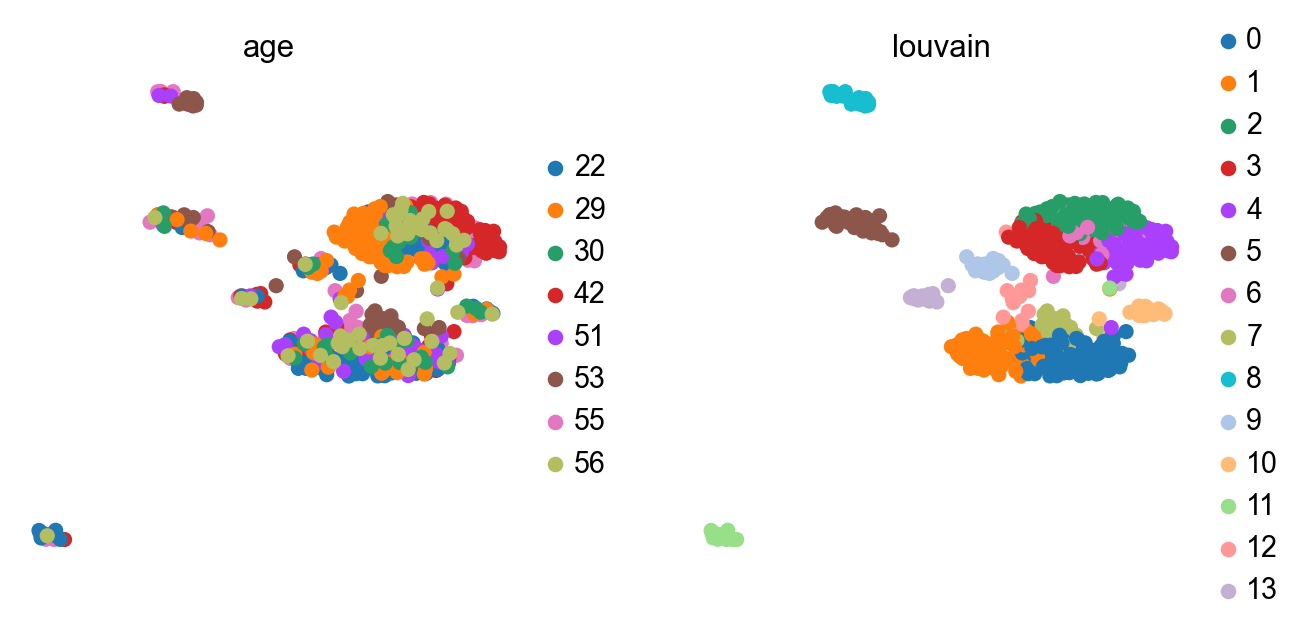

In [128]:
sc.pl.umap(lawlor, color=['age', 'louvain'])

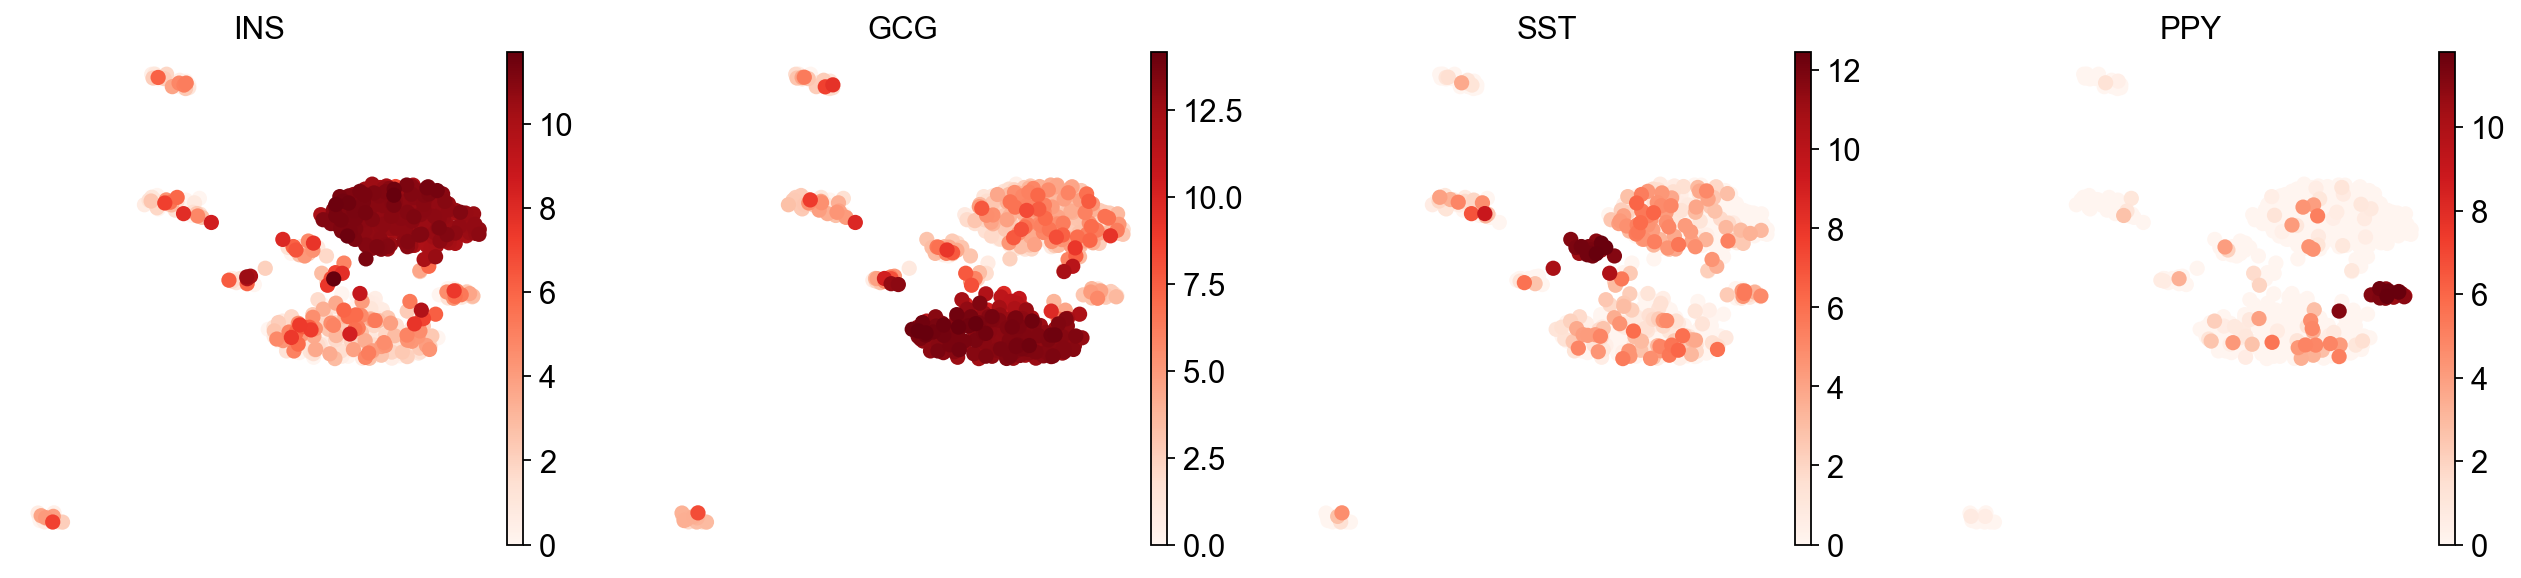

In [129]:
sc.pl.umap(lawlor, color=['INS', 'GCG', 'SST', 'PPY'])

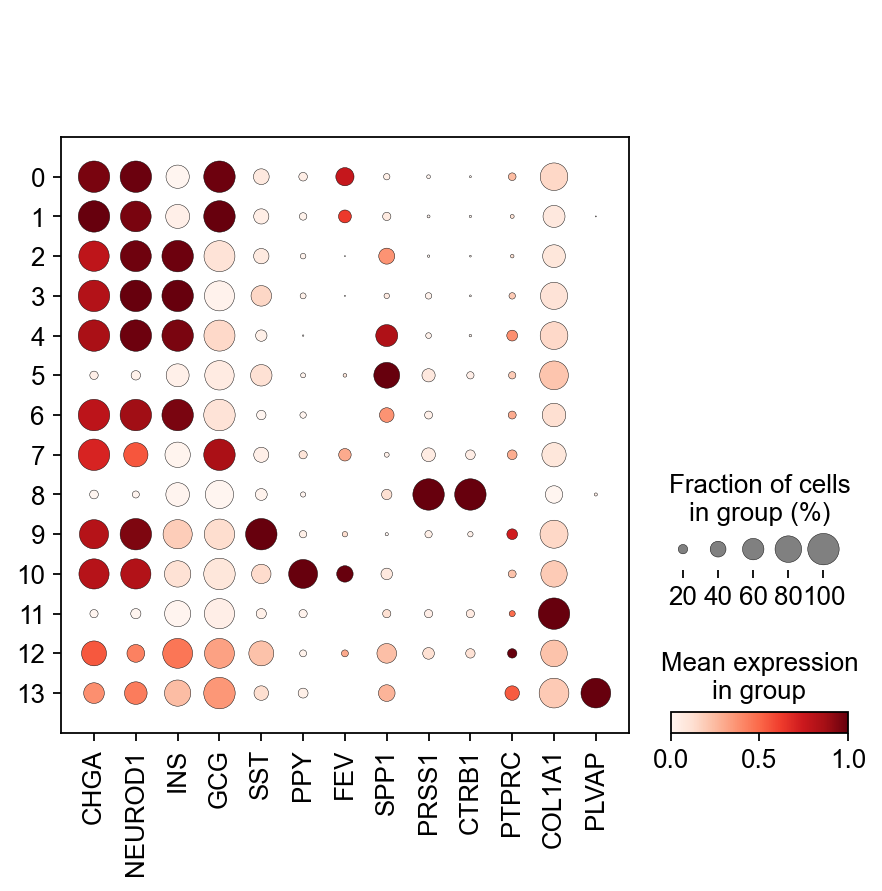

In [130]:
sc.pl.dotplot(lawlor, groupby='louvain', 
              var_names=['CHGA', 'NEUROD1', 'INS', 'GCG', 'SST', 'PPY', 'FEV', 'SPP1', 'PRSS1', 'CTRB1', 'PTPRC', 'COL1A1', 'PLVAP'], 
              standard_scale='var')

In [131]:
map_names = {}

for c in lawlor.obs['louvain'].cat.categories:
    if c in ['2', '3', '4', '6']:
        map_names[c] = 'beta'
    elif c in ['0', '1', '7']:
        map_names[c] = 'alpha'  
    elif c in ['9']:
        map_names[c] = 'delta'
    elif c in ['10']:
        map_names[c] = 'PP'    
    elif c in ['12']:
        map_names[c] = 'polyhormonal'
    elif c in ['5']:
        map_names[c] = 'ductal' 
    elif c in ['8']:
        map_names[c] = 'acinar' 
    elif c in ['13']:
        map_names[c] = 'endothelial'
    elif c in ['11']:
        map_names[c] = 'stellate/fibroblast'
    else:
        map_names[c] = c

lawlor.obs['louvain_anno_broad'] = lawlor.obs['louvain']
lawlor.obs['louvain_anno_broad'] = lawlor.obs['louvain_anno_broad'].map(map_names).astype('category')

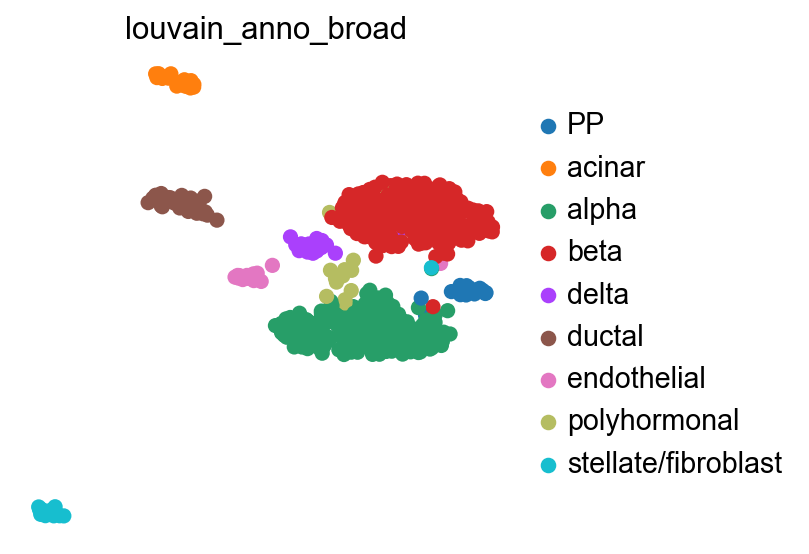

In [132]:
sc.pl.umap(lawlor, color=['louvain_anno_broad'])

In [129]:
lawlor.obs['study'] = 'Lawlor et al, 2016'

In [155]:
lawlor.obs['donor'] = lawlor.obs['age'].copy()

In [156]:
lawlor.X = csr_matrix(lawlor.X)
lawlor.write('./data/lawlor.h5ad')

## Muraro et al.

Data downloaded from: [GSE85241](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE85241)

In [175]:
muraro = sc.read_csv('./data/Muraro_GSE85241/GSE85241_cellsystems_dataset_4donors_updated.csv.gz', delimiter='\t').T

In [176]:
muraro

AnnData object with n_obs × n_vars = 3072 × 19140

In [177]:
muraro.var_names = [x.split('__')[0] for x in muraro.var_names]

In [178]:
muraro.obs['donor'] = [x.split('_')[0].split('-')[0] for x in muraro.obs_names]
muraro.obs['donor_library'] = [x.split('_')[0] for x in muraro.obs_names]

In [179]:
muraro.obs.donor.value_counts()

D28    768
D29    768
D31    768
D30    768
Name: donor, dtype: int64

In [89]:
# from table S1
meta = pd.DataFrame(
    [['D28', 'male', '54', '26'],
    ['D29', 'male', '23', '22'],
    ['D30', 'female', '48', '26'],
    ['D31', 'male', '59', '25']],
    columns = ['donor', 'sex', 'age', 'bmi'])
meta.set_index('donor', inplace=True)

In [90]:
muraro.obs['age'] = meta.loc[muraro.obs.donor]['age'].tolist()
muraro.obs['sex'] = meta.loc[muraro.obs.donor]['sex'].tolist()
muraro.obs['bmi'] = meta.loc[muraro.obs.donor]['bmi'].tolist()
muraro.obs['condition'] = 'healthy'

In [180]:
muraro.var_names_make_unique()

In [181]:
# remove ERCCs
muraro = muraro[:, [gene for gene in muraro.var_names if not 'ERCC-' in gene]].copy()

In [182]:
sc.pp.filter_cells(muraro, min_counts=200)
sc.pp.filter_cells(muraro, min_genes=200)

filtered out 268 cells that have less than 200 counts
filtered out 164 cells that have less than 200 genes expressed


In [183]:
#remove genes not seen in 10 cells
sc.pp.filter_genes(muraro, min_cells=10)

filtered out 2761 genes that are detected in less than 10 cells


In [184]:
sc.pp.normalize_total(muraro, exclude_highly_expressed=True)
sc.pp.log1p(muraro)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['CPA1', 'CTRB2', 'FTH1', 'FTL', 'GCG', 'GHRL', 'GNAS', 'IAPP', 'INS', 'MALAT1', 'MMP3', 'MTRNR2L1', 'MTRNR2L2', 'MTRNR2L8', 'PPY', 'RBP4', 'REG1A', 'REG1B', 'REG3A', 'SST', 'TTR']
    finished (0:00:00)


### Manifold and clustering

In [185]:
sc.pp.highly_variable_genes(muraro, n_top_genes=2000)
sc.pp.pca(muraro)
sc.pp.neighbors(muraro)
sc.tl.umap(muraro)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


In [186]:
sc.tl.louvain(muraro, resolution=1.8)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 18 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


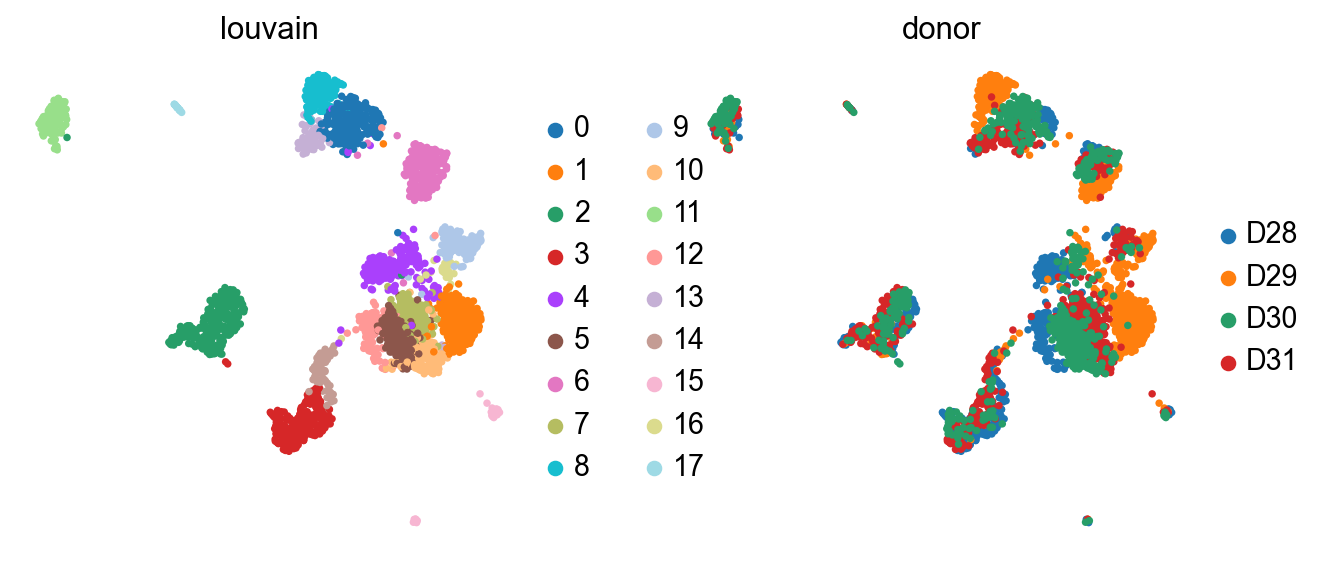

In [188]:
sc.pl.umap(muraro, color=['louvain', 'donor'])

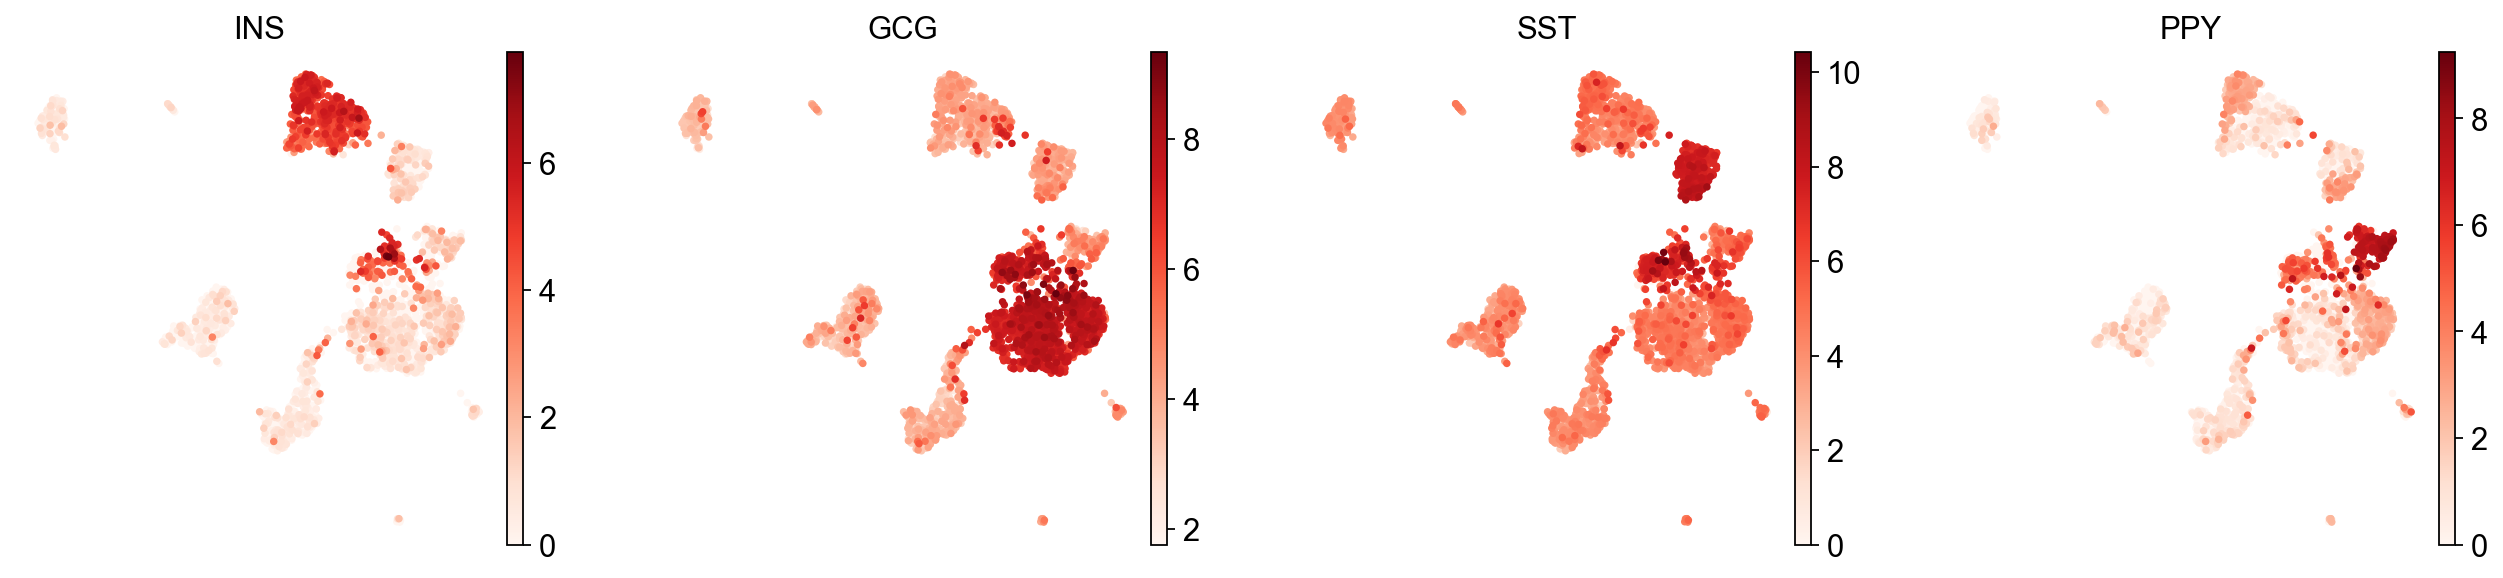

In [189]:
sc.pl.umap(muraro, color=['INS', 'GCG', 'SST', 'PPY'])

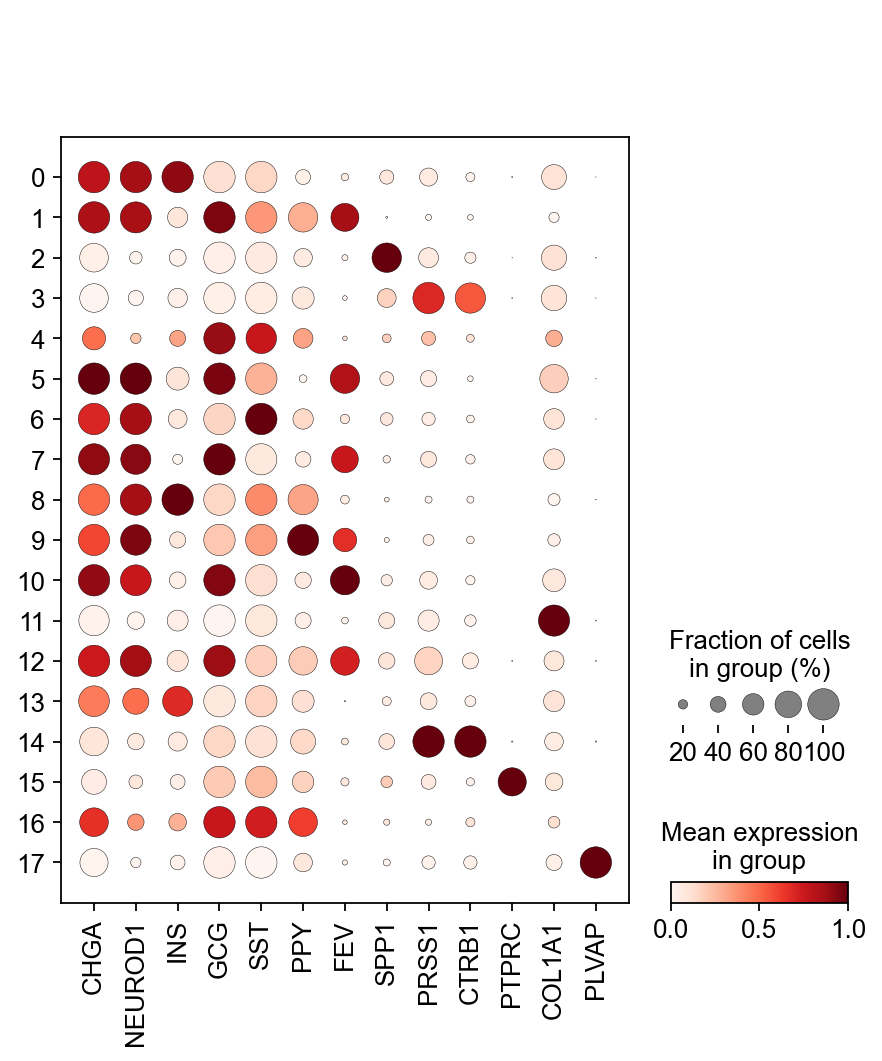

In [190]:
sc.pl.dotplot(muraro, groupby='louvain', 
              var_names=['CHGA', 'NEUROD1', 'INS', 'GCG', 'SST', 'PPY', 'FEV', 'SPP1', 'PRSS1', 'CTRB1', 'PTPRC', 'COL1A1', 'PLVAP'], 
              standard_scale='var')

In [194]:
map_names = {}

for c in muraro.obs['louvain'].cat.categories:
    if c in ['0', '8', '13']:
        map_names[c] = 'beta'
    elif c in ['1', '5', '7', '10', '12']:
        map_names[c] = 'alpha'  
    elif c in ['6']:
        map_names[c] = 'delta'
    elif c in ['9']:
        map_names[c] = 'PP'    
    elif c in ['4', '16']:
        map_names[c] = 'polyhormonal'
    elif c in ['2']:
        map_names[c] = 'ductal' 
    elif c in ['14', '3']:
        map_names[c] = 'acinar' 
    elif c in ['17']:
        map_names[c] = 'endothelial'
    elif c in ['11']:
        map_names[c] = 'stellate/fibroblast'
    elif c in ['15']:
        map_names[c] = 'immune'
        
    else:
        map_names[c] = c

muraro.obs['louvain_anno_broad'] = muraro.obs['louvain']
muraro.obs['louvain_anno_broad'] = muraro.obs['louvain_anno_broad'].map(map_names).astype('category')

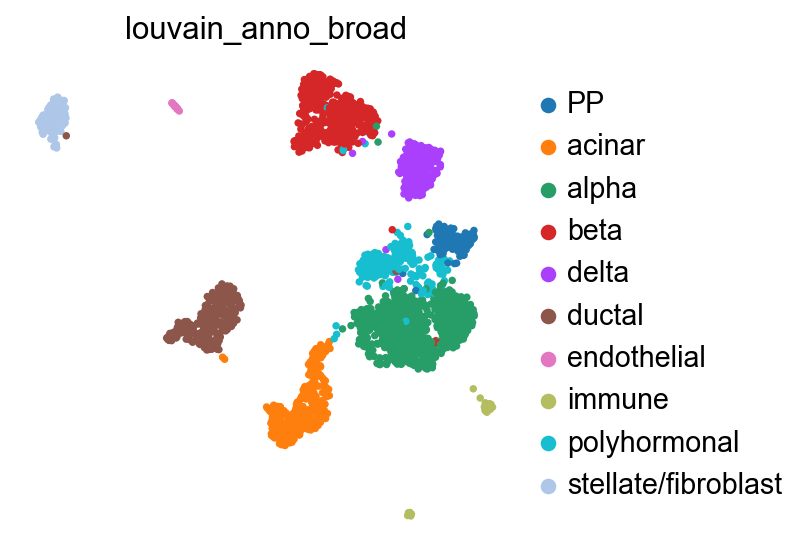

In [195]:
sc.pl.umap(muraro, color=['louvain_anno_broad'])

In [126]:
muraro.obs['study'] = 'Muraro et al, 2016'

In [128]:
muraro.X = csr_matrix(muraro.X)
muraro.write('./data/muraro.h5ad')

## Enge et al.

Data downloaded from: [GSE81547](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE81547)

In [206]:
import os
path = './data/Enge_GSE81547_RAW/'
ixs = os.listdir(path)

In [207]:
ixs.remove('.DS_Store')

In [208]:
ixs = sorted(ixs)

In [215]:
adatas = []
for ix in ixs:
    adata = sc.read_csv(f'{path}{ix}', delimiter='\t').T
    adata.var_names_make_unique()
    adatas.append(adata)

In [216]:
enge = adatas[0].concatenate(adatas[1:])

In [240]:
enge = sc.read('./data/enge_raw.h5ad', compression='gzip')

In [247]:
enge.obs_names = [x.rsplit('.',2)[0] for x in ixs]

In [248]:
enge.obs['geo_sample'] = [x.split('_')[0] for x in enge.obs_names]

In [254]:
meta = pd.read_csv('./data/GSE81547_series_matrix.txt', sep='\t', index_col=0).T

In [257]:
meta.set_index('geo_accession', inplace=True)

In [259]:
meta.head()

title         characteristics_ch1 characteristics_ch1 characteristics_ch1
geo_accession                                                            
GSM2171880                     21                male               alpha
GSM2171881                     21                male               alpha
GSM2171882                     21                male              acinar
GSM2171883                     21                male               alpha
GSM2171884                     21                male               alpha

In [260]:
meta.columns = ['age', 'sex', 'cell type']

In [261]:
enge.obs = meta.loc[enge.obs.geo_sample].copy()

In [263]:
##### filter ambigous gene names at the end
enge = enge[:, ~enge.var_names.isin(['tAKR', 'no_feature', 'ambiguous', 'too_low_aQual', 'not_aligned', 'alignment_not_unique'])].copy()

In [264]:
sc.pp.filter_cells(enge, min_counts=200)
sc.pp.filter_cells(enge, min_genes=200)

In [265]:
#remove genes not seen in 10 cells
sc.pp.filter_genes(enge, min_cells=10)

filtered out 6134 genes that are detected in less than 10 cells


In [266]:
sc.pp.normalize_total(enge, exclude_highly_expressed=True)
sc.pp.log1p(enge)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['CELA3A', 'CLPS', 'CPA1', 'CPB1', 'CTRC', 'ERCC-00002', 'ERCC-00074', 'ERCC-00096', 'ERCC-00130', 'GCG', 'GP2', 'HSPA5', 'IAPP', 'IL8', 'INS', 'MALAT1', 'MUC6', 'OLFM4', 'PNLIP', 'PPY', 'PRSS1', 'REG1A', 'REG1B', 'REG3A', 'SERPINA1', 'SPP1', 'SST', 'THBS1', 'TTR']
    finished (0:00:00)


### Manifold and clustering

In [275]:
sc.pp.highly_variable_genes(enge, n_top_genes=2000)
sc.pp.pca(enge)
bbknn.bbknn(enge, batch_key='age')
sc.tl.umap(enge)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP


/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


In [290]:
sc.tl.louvain(enge, resolution=2)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


In [292]:
sc.tl.louvain(enge, restrict_to=('louvain', ['8']), key_added='louvain_R')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 13 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)


In [296]:
sc.tl.louvain(enge, restrict_to=('louvain_R', ['9']), key_added='louvain_R')

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)


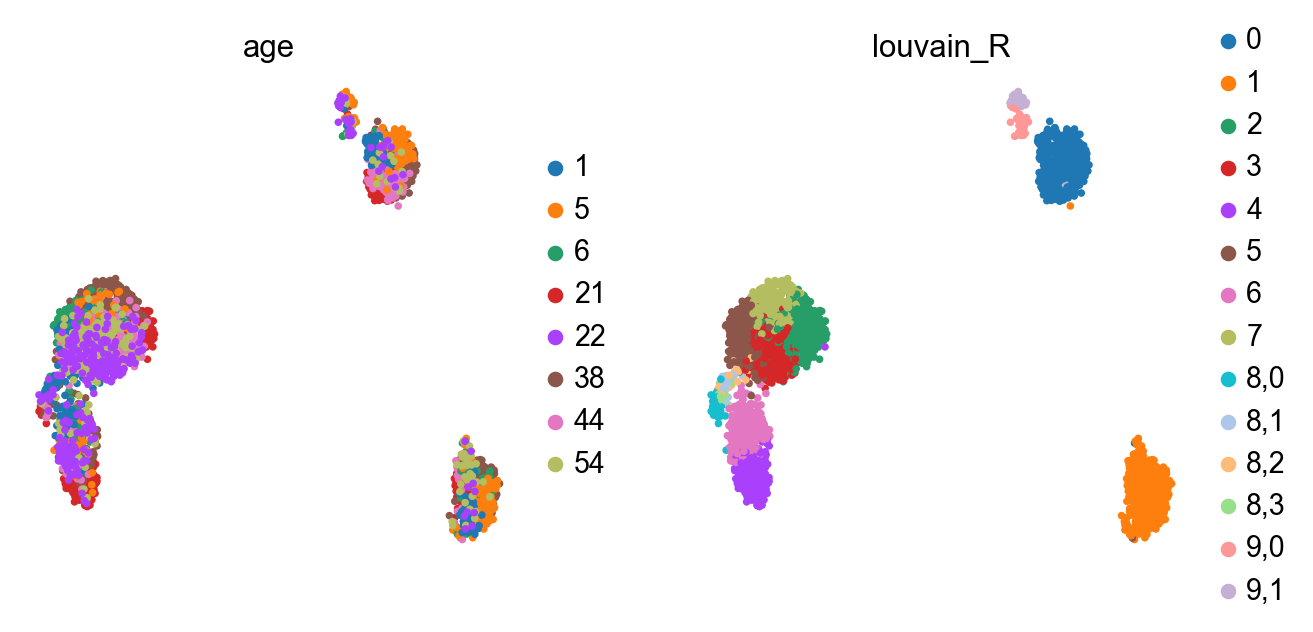

In [297]:
sc.pl.umap(enge, color=['age', 'louvain_R'])

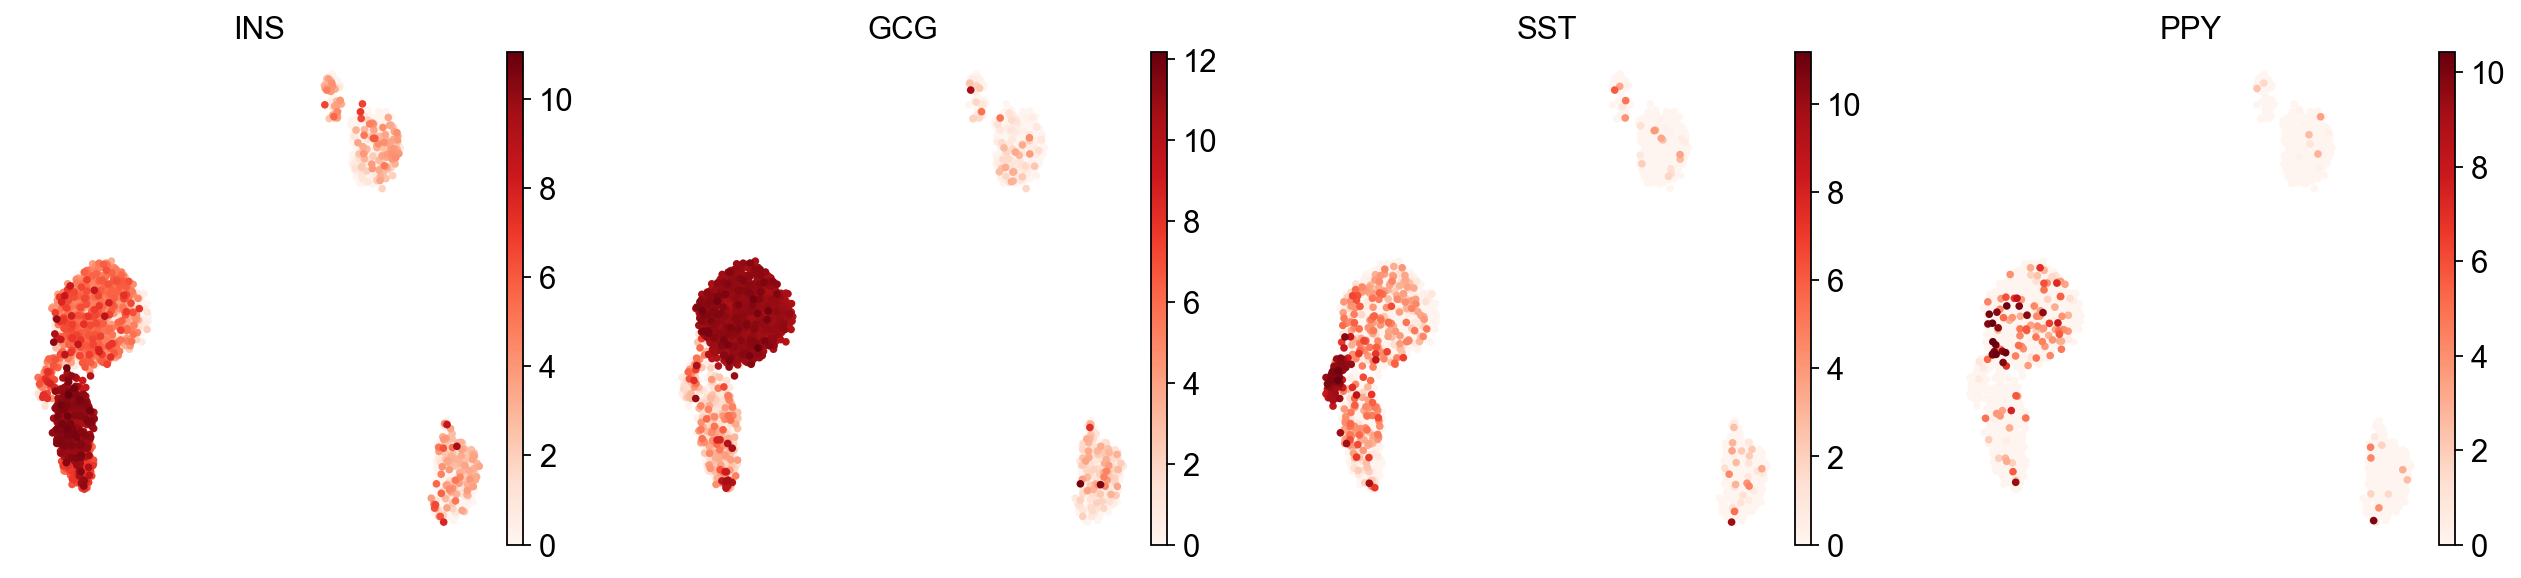

In [294]:
sc.pl.umap(enge, color=['INS', 'GCG', 'SST', 'PPY'])

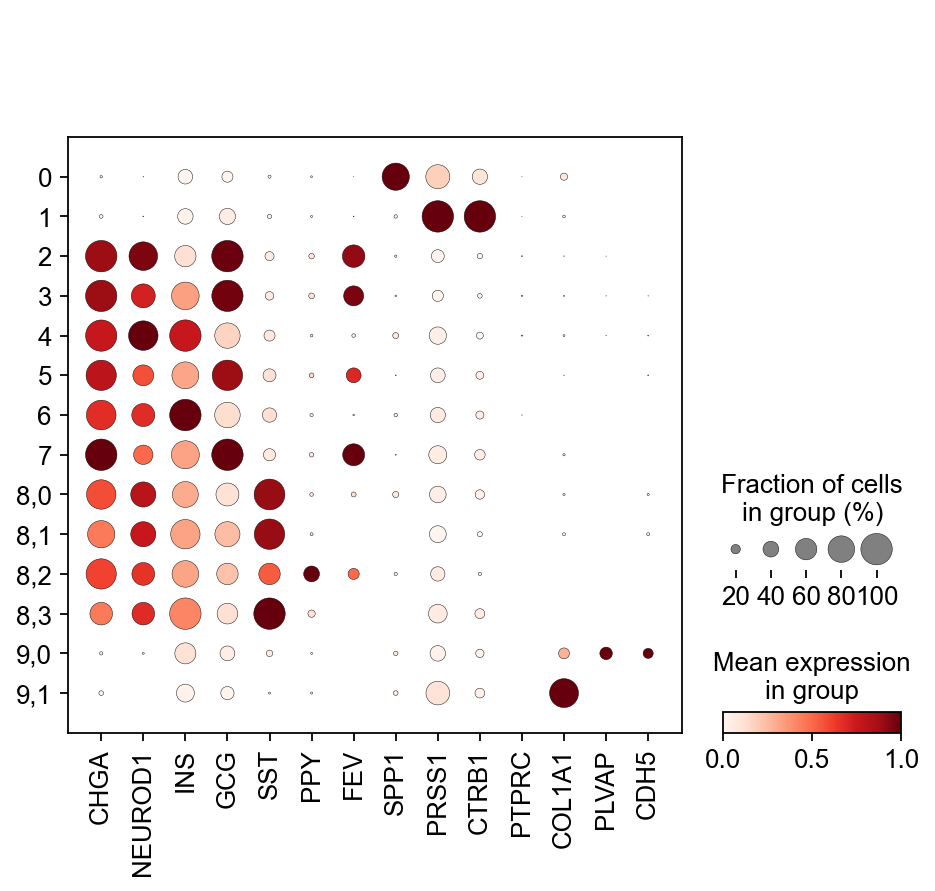

In [299]:
sc.pl.dotplot(enge, groupby='louvain_R', 
              var_names=['CHGA', 'NEUROD1', 'INS', 'GCG', 'SST', 'PPY', 'FEV', 'SPP1', 'PRSS1', 'CTRB1', 'PTPRC', 'COL1A1', 'PLVAP', 'CDH5'], 
              standard_scale='var')

In [300]:
map_names = {}

for c in enge.obs['louvain_R'].cat.categories:
    if c in ['4', '6']:
        map_names[c] = 'beta'
    elif c in ['2', '3', '5', '7']:
        map_names[c] = 'alpha'  
    elif c in ['8,0', '8,1', '8,3']:
        map_names[c] = 'delta'
    elif c in ['8,2']:
        map_names[c] = 'PP'    
    elif c in ['0']:
        map_names[c] = 'ductal' 
    elif c in ['1']:
        map_names[c] = 'acinar' 
    elif c in ['9,0']:
        map_names[c] = 'endothelial'
    elif c in ['9,1']:
        map_names[c] = 'stellate/fibroblast'
    else:
        map_names[c] = c

enge.obs['louvain_anno_broad'] = enge.obs['louvain_R']
enge.obs['louvain_anno_broad'] = enge.obs['louvain_anno_broad'].map(map_names).astype('category')

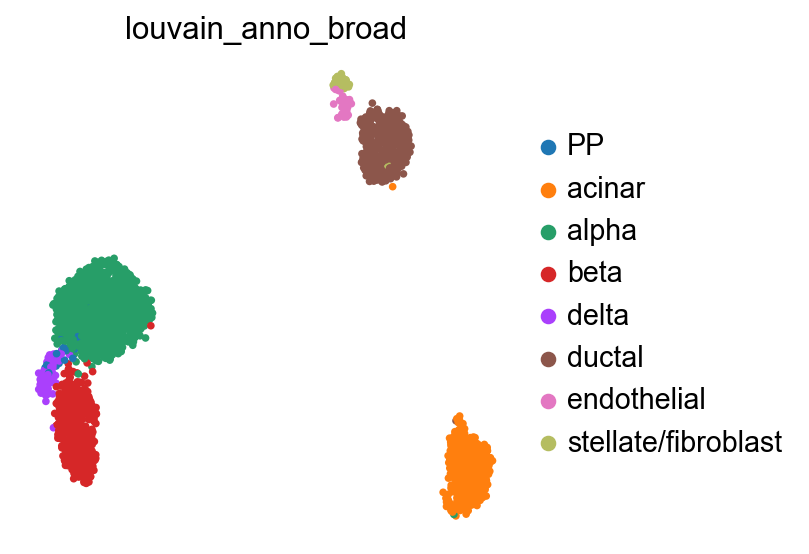

In [301]:
sc.pl.umap(enge, color=['louvain_anno_broad'])

In [123]:
enge.obs['condition'] = 'healthy'
enge.obs['study'] = 'Enge et al, 2017'

In [153]:
enge.obs['donor'] = enge.obs['age'].copy()

In [154]:
enge.X = csr_matrix(enge.X)
enge.write('./data/enge.h5ad')

## Shrestha et al.

Data downloaded from [GSE183568](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE183568)

In [160]:
shrestha = sc.read_csv('./data/Shrestha_GSE183568_raw_gene_cell_counts.txt', delimiter='\t')

In [163]:
shrestha = shrestha.T.copy()

In [164]:
shrestha.X = csr_matrix(shrestha.X)

In [167]:
meta = pd.read_csv('./data/Shrestha_GSE183568_scRNAseq_metadata.txt', sep='\t')

In [169]:
shrestha.obs = meta.loc[shrestha.obs_names]

In [182]:
shrestha.obs.rename(columns={'Age':'age', 'Sex':'sex', 'Replicates':'donor_replicate'}, inplace=True)

In [177]:
shrestha.obs.age.unique()

array(['50y', '59y', '66y', '39y', '14y'], dtype=object)

In [179]:
shrestha.obs['age'] = [x.replace('y', '') for x in shrestha.obs.age]
shrestha.obs['donor'] = shrestha.obs['age'].copy()

In [184]:
shrestha.obs['condition'] = 'healthy'
shrestha.obs['study'] = 'Shrestha et al, 2021'

In [186]:
sc.pp.filter_cells(shrestha, min_counts=200)
sc.pp.filter_cells(shrestha, min_genes=200)

In [187]:
#remove genes not seen in 10 cells
sc.pp.filter_genes(shrestha, min_cells=10)

filtered out 3955 genes that are detected in less than 10 cells


In [188]:
sc.pp.normalize_total(shrestha, exclude_highly_expressed=True)
sc.pp.log1p(shrestha)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['CELA3A', 'S100A6', 'REG1B', 'REG1A', 'REG3A', 'GCG', 'IGFBP5', 'GHRL', 'TM4SF1', 'SST', 'CXCL8', 'SPP1', 'SPINK1', 'CLPS', 'HSPB1', 'PRSS2', 'PRSS1', 'TMSB4X', 'TIMP1', 'CLU', 'HSPA5', 'INS', 'FTH1', 'MALAT1', 'MMP7', 'MMP1', 'IAPP', 'MT2A', 'MT1G', 'MT1X', 'CTRB2', 'CCL3L3', 'PPY', 'TTR', 'CHGB', 'FTL', 'TFF1']
    finished (0:00:02)


### Manifold and clustering

In [189]:
sc.pp.highly_variable_genes(shrestha, n_top_genes=2000)
sc.pp.pca(shrestha)
sc.pp.neighbors(shrestha)
sc.tl.umap(shrestha)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50


/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:24)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:33)


In [190]:
sc.tl.louvain(shrestha)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 20 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:06)


In [196]:
sc.tl.louvain(shrestha, restrict_to=('louvain', ['17']), key_added='louvain_R', resolution=0.3)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 21 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)


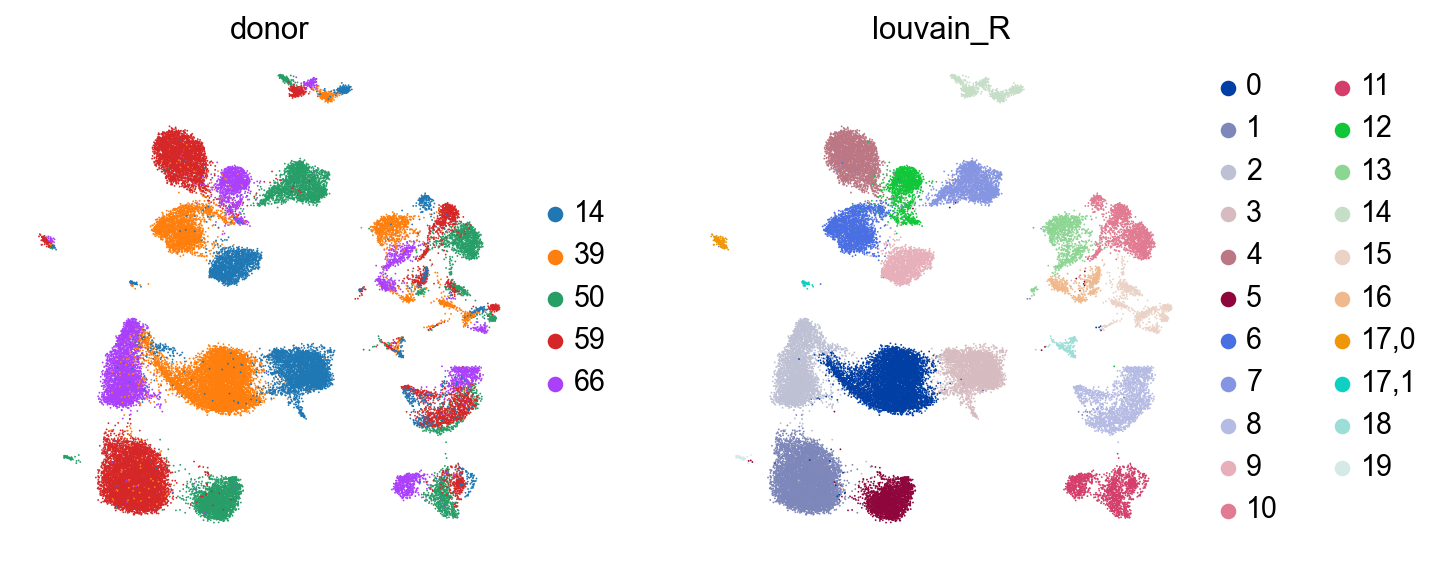

In [206]:
sc.pl.umap(shrestha, color=['donor', 'louvain_R'])

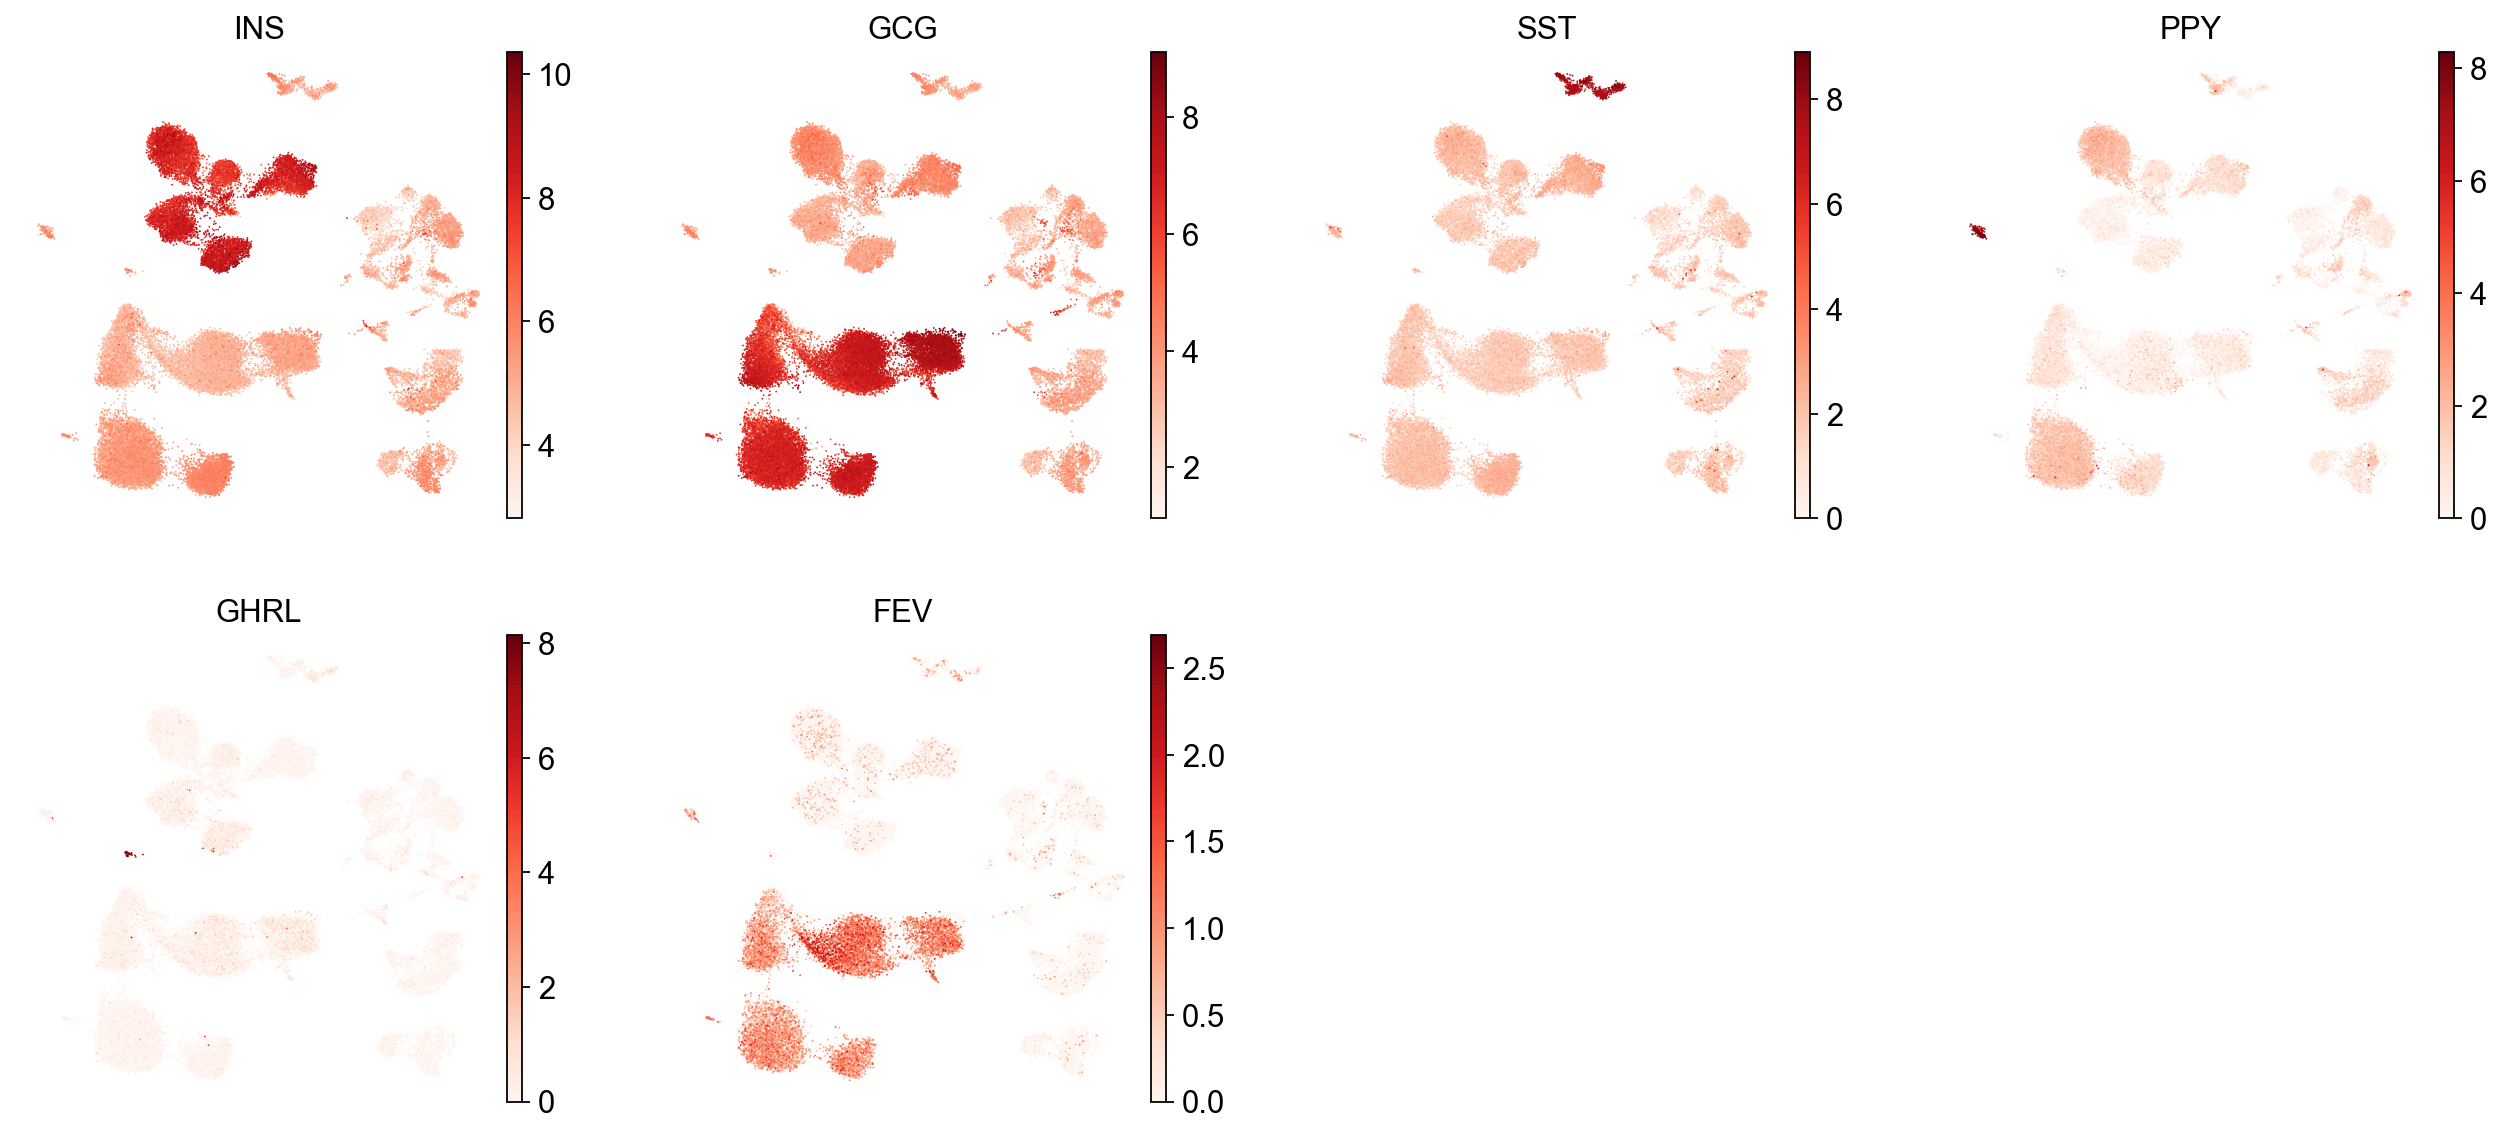

In [205]:
sc.pl.umap(shrestha, color=['INS', 'GCG', 'SST', 'PPY', 'GHRL', 'FEV'])

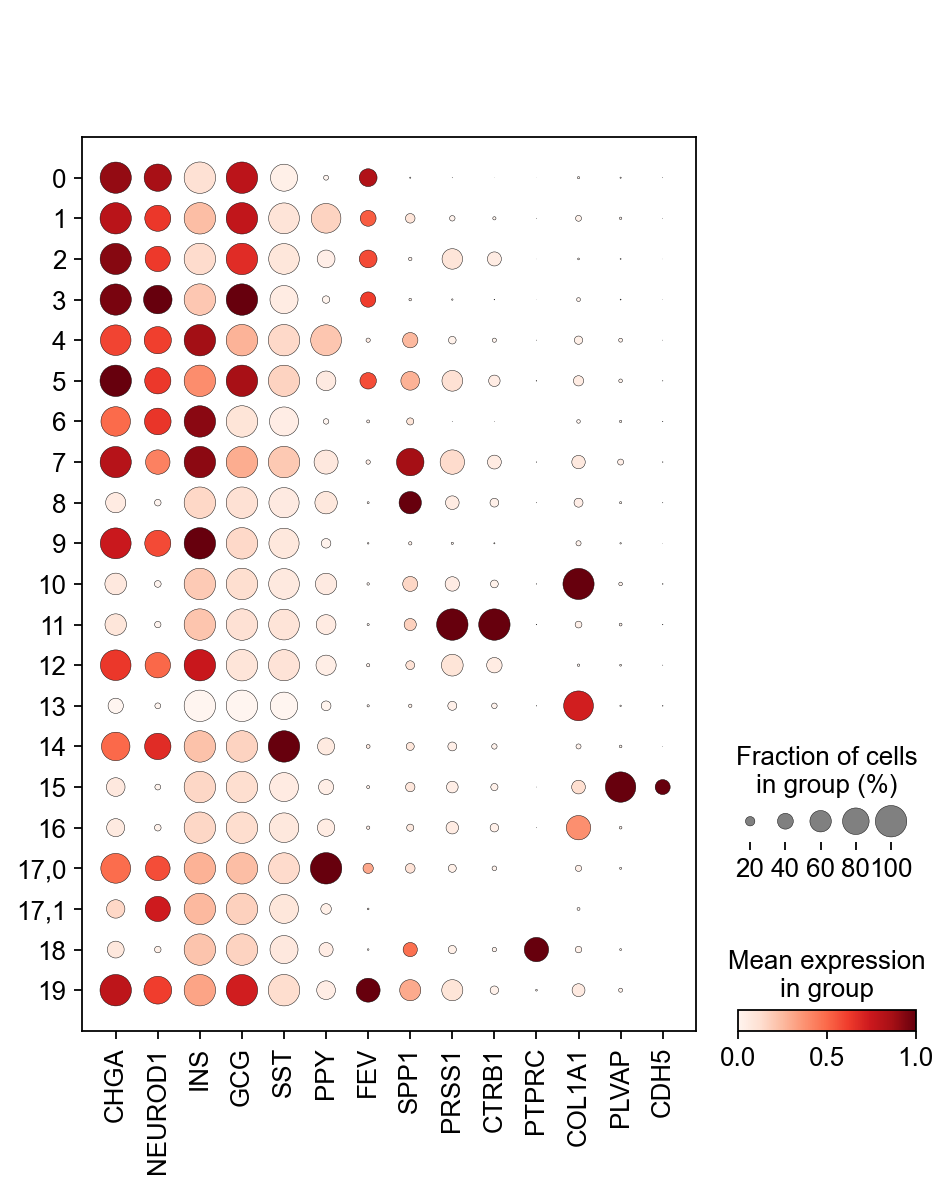

In [199]:
sc.pl.dotplot(shrestha, groupby='louvain_R', 
              var_names=['CHGA', 'NEUROD1', 'INS', 'GCG', 'SST', 'PPY', 'FEV', 'SPP1', 'PRSS1', 'CTRB1', 'PTPRC', 'COL1A1', 'PLVAP', 'CDH5'], 
              standard_scale='var')

In [209]:
map_names = {}

for c in shrestha.obs['louvain_R'].cat.categories:
    if c in ['4', '6', '7', '9', '12']:
        map_names[c] = 'beta'
    elif c in ['0', '1', '2', '3', '5', '19']:
        map_names[c] = 'alpha'  
    elif c in ['14']:
        map_names[c] = 'delta'
    elif c in ['17,0']:
        map_names[c] = 'PP'   
    elif c in ['17,1']:
        map_names[c] = 'epsilon'   
    elif c in ['8']:
        map_names[c] = 'ductal' 
    elif c in ['11']:
        map_names[c] = 'acinar' 
    elif c in ['15']:
        map_names[c] = 'endothelial'
    elif c in ['13', '16', '10']:
        map_names[c] = 'stellate/fibroblast'
    elif c in ['18']:
        map_names[c] = 'immune'

    else:
        map_names[c] = c

shrestha.obs['louvain_anno_broad'] = shrestha.obs['louvain_R']
shrestha.obs['louvain_anno_broad'] = shrestha.obs['louvain_anno_broad'].map(map_names).astype('category')

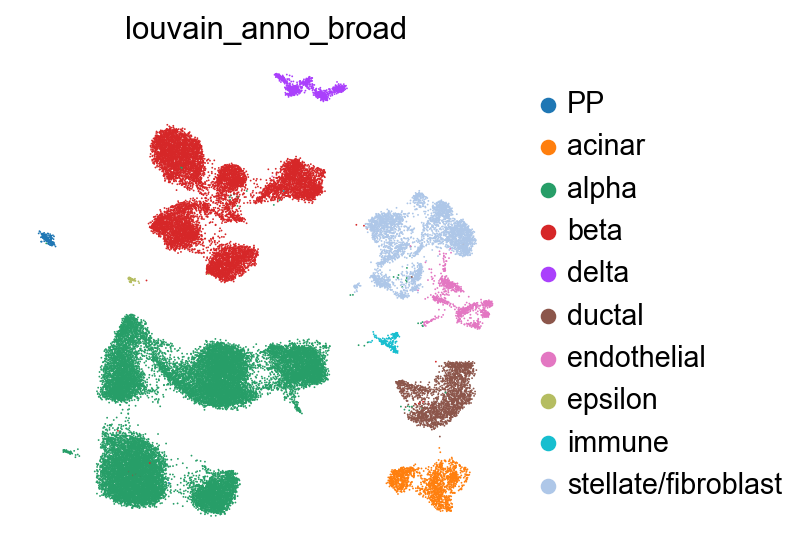

In [210]:
sc.pl.umap(shrestha, color=['louvain_anno_broad'])

In [211]:
shrestha.write('./data/shrestha.h5ad')

## Son et al.

Data downloaded from [GSE98887](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE98887)

In [212]:
son = sc.read_csv('./data/Son_GSE98887_counts.csv.gz').T

In [218]:
son = son.T.copy()

In [164]:
son.X = csr_matrix(son.X)

In [221]:
son.var_names

Index(['1', '10', '100', '1000', '10000', '100008586', '100008587',
       '100009613', '100009667', '100009676',
       ...
       '9987', '9988', '9989', '999', '9990', '9991', '9992', '9993', '9994',
       '9997'],
      dtype='object', length=26471)

count matrix cannot be used as gene names are missing...

In [223]:
del son

## Fasolino et al.

Data downloaded from [cellxgene portal](https://cellxgene.cziscience.com/collections/51544e44-293b-4c2b-8c26-560678423380)

In [231]:
fasolino = sc.read('./data/fasolino_raw.h5ad')

In [238]:
fasolino.obs['donor'] = [x.split('-')[1] for x in fasolino.obs_names]

In [280]:
fasolino.obs.disease_state.unique()

['Control', 'AAB', 'T1D']
Categories (3, object): ['AAB', 'Control', 'T1D']

In [282]:
fasolino.obs['condition'] = fasolino.obs['disease_state'].copy()
fasolino.obs['condition'].replace({
    'Control': 'healthy',
    'AAB': 'T1D AAB',
    'type 1 diabetes mellitus': 'T1D'
}, inplace=True)

In [283]:
fasolino.obs['study'] = 'Fasolino et al, 2022'

In [258]:
sc.pp.filter_cells(fasolino, min_counts=200)
sc.pp.filter_cells(fasolino, min_genes=200)

In [259]:
#remove genes not seen in 10 cells
sc.pp.filter_genes(fasolino, min_cells=10)

filtered out 2709 genes that are detected in less than 10 cells


In [260]:
sc.pp.normalize_total(fasolino, exclude_highly_expressed=True)
sc.pp.log1p(fasolino)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
[]
    finished (0:00:03)


### Manifold and clustering

In [267]:
import bbknn as bbknn
sc.pp.highly_variable_genes(fasolino, n_top_genes=2000)
sc.pp.pca(fasolino)
bbknn.bbknn(fasolino, batch_key='donor')
sc.tl.umap(fasolino)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:38)
computing UMAP


/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:18)


In [271]:
sc.tl.louvain(fasolino, resolution=2)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:01:01)


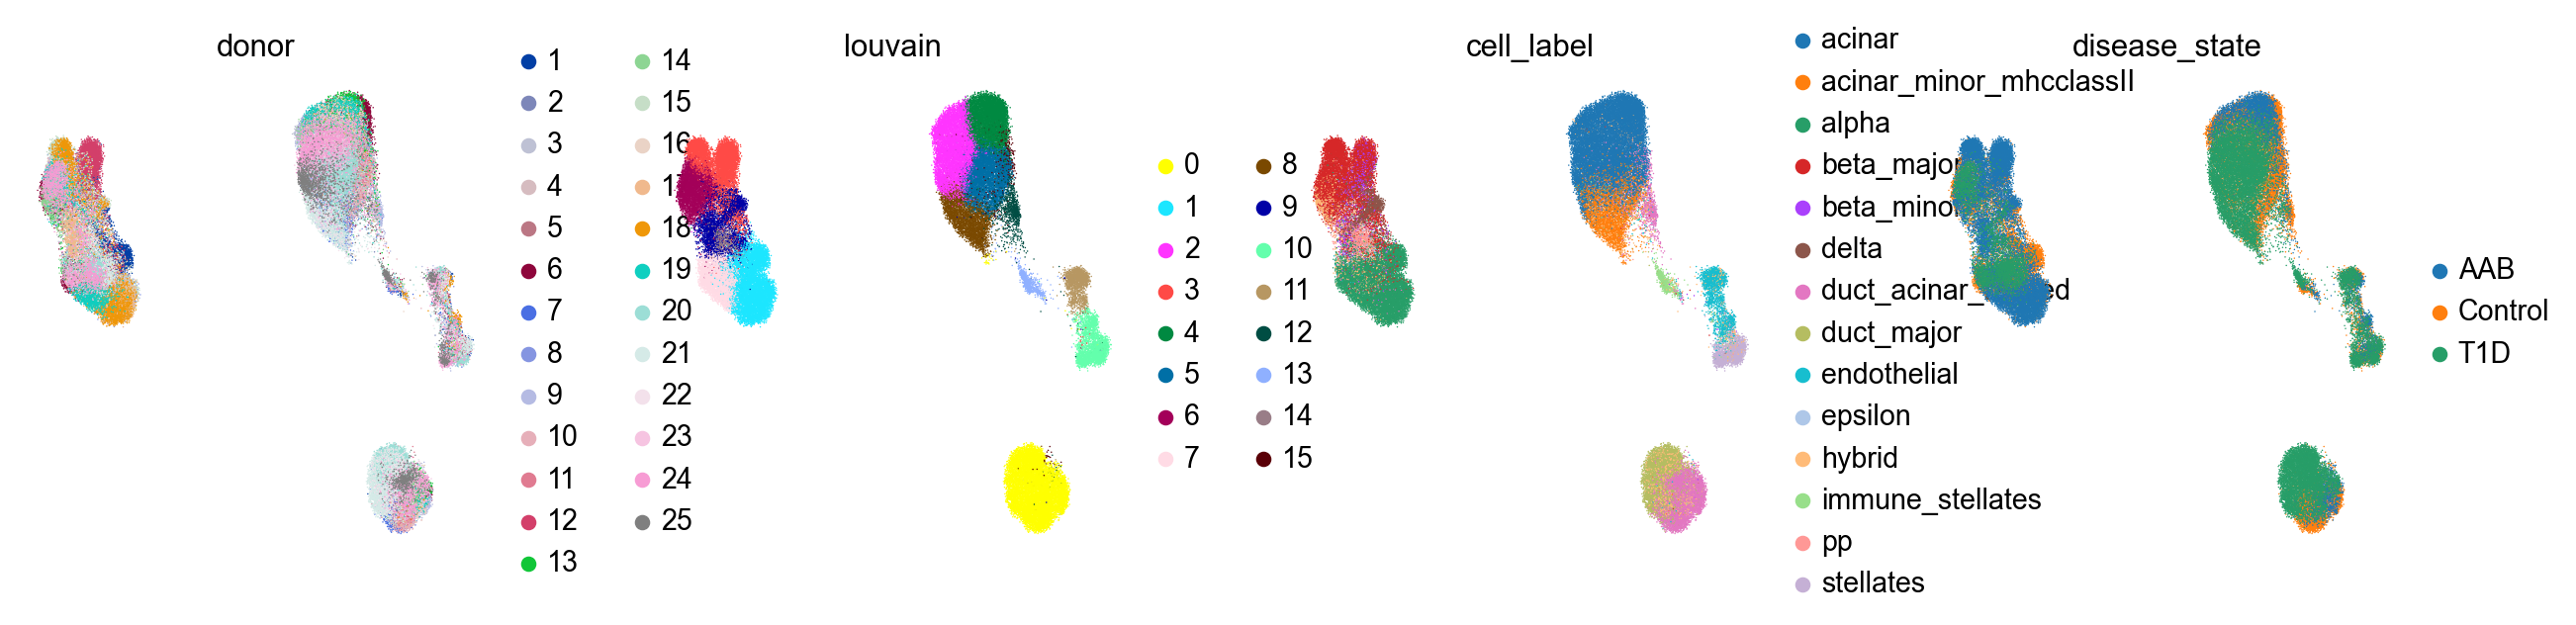

In [275]:
sc.pl.umap(fasolino, color=['donor', 'louvain', 'cell_label', 'disease_state'])

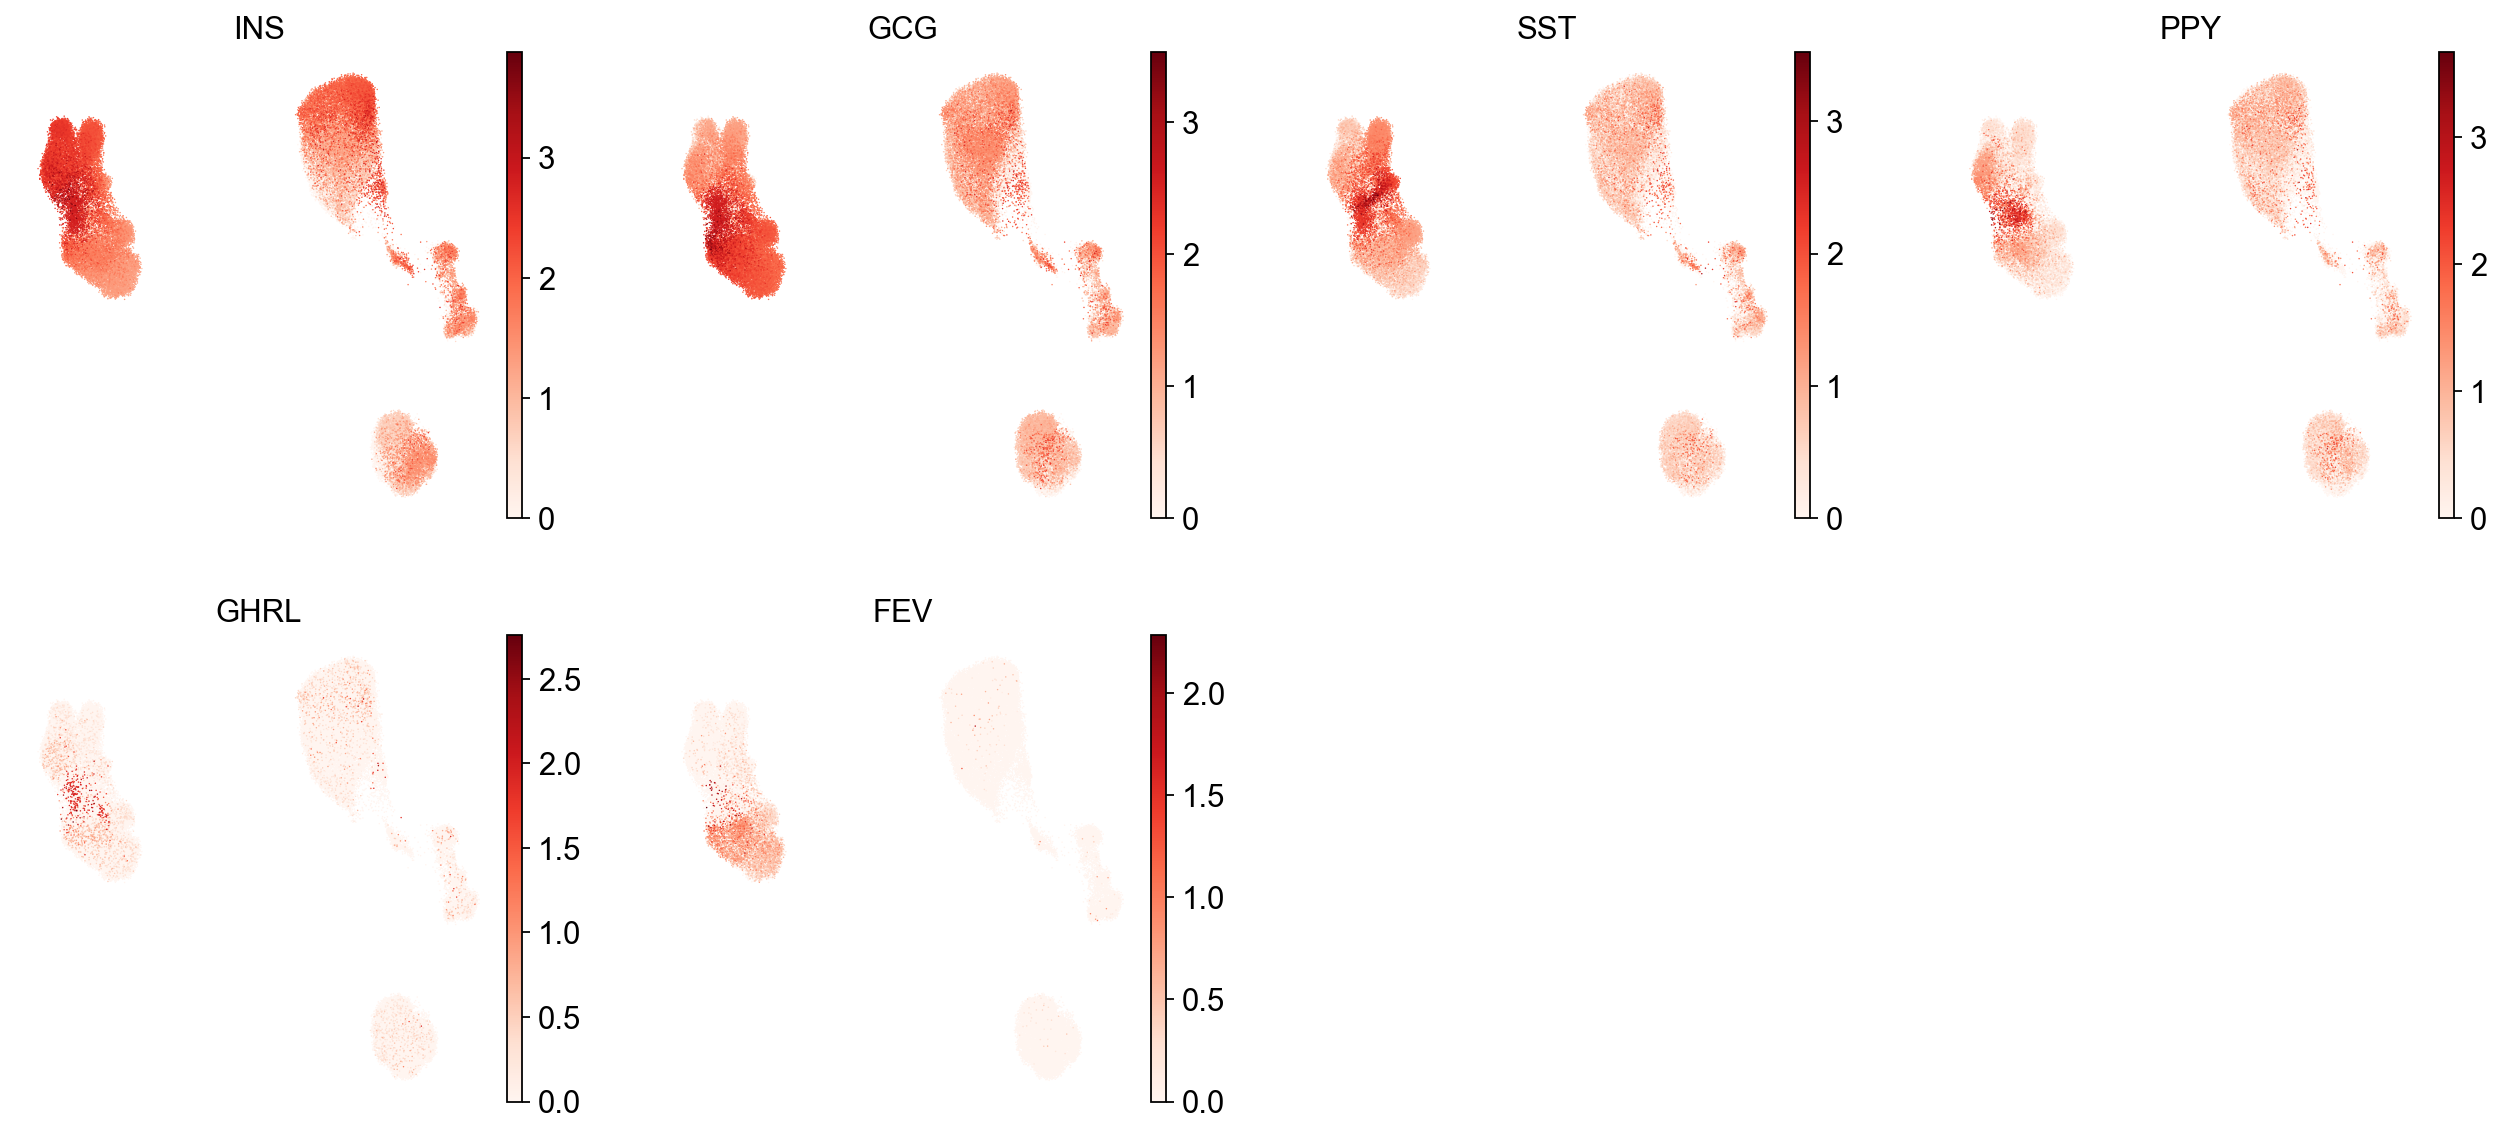

In [270]:
sc.pl.umap(fasolino, color=['INS', 'GCG', 'SST', 'PPY', 'GHRL', 'FEV'])

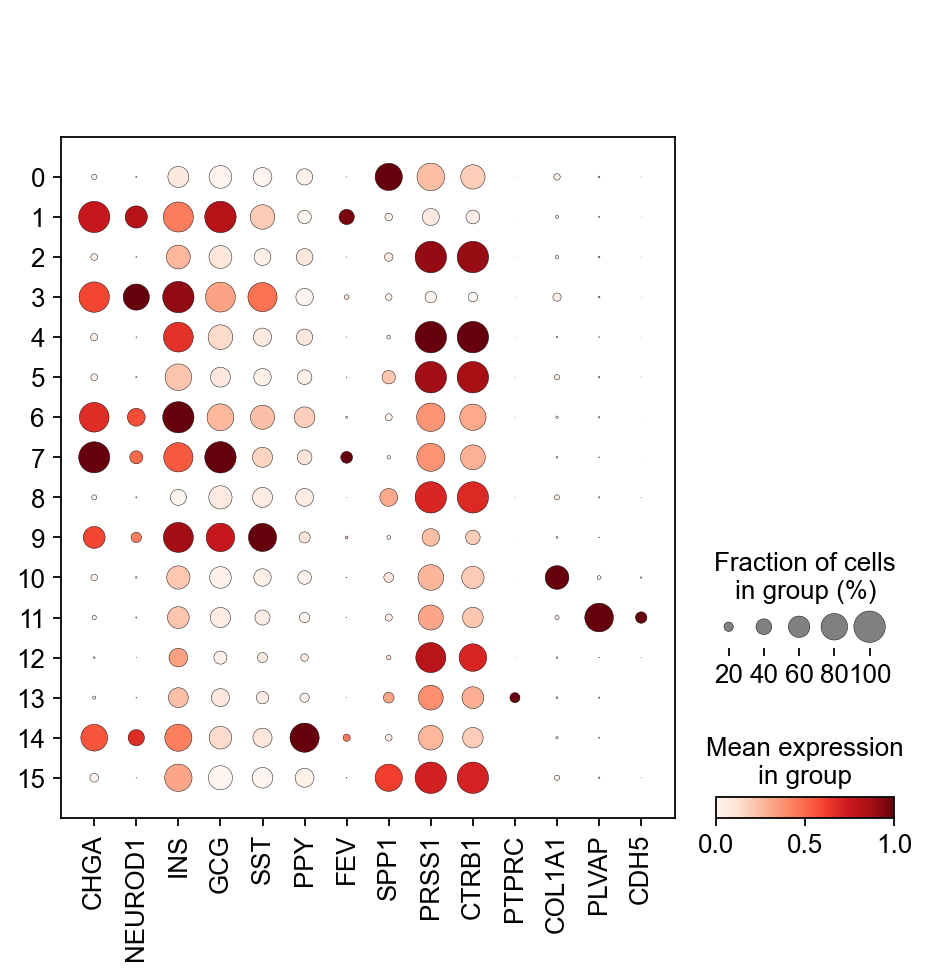

In [276]:
sc.pl.dotplot(fasolino, groupby='louvain', var_names=['CHGA', 'NEUROD1', 'INS', 'GCG', 'SST', 'PPY', 'FEV', 'SPP1', 'PRSS1', 'CTRB1', 'PTPRC', 'COL1A1', 'PLVAP', 'CDH5'], standard_scale='var')

In [277]:
pd.crosstab(fasolino.obs.cell_label, fasolino.obs.louvain)

louvain                     0     1     2     3     4     5     6     7     8  \
cell_label                                                                      
acinar                      0     1  7520     0  5865  4644     3     1   761   
acinar_minor_mhcclassII    44     9   236     0    15  1175     3     6  2464   
alpha                       2  7903     1    92     0     0   169  3100     0   
beta_major                  4   400     8  5388     2     0  3014    99     0   
beta_minor                 13    54     1   722     1     1   150    47     1   
delta                       1    29     1   149     1     1    56    15     0   
duct_acinar_related      4722    99    20     1    44    62     4    60    47   
duct_major               5870     0     5     0     0     6     0     1    32   
endothelial                41     2    19     3     1    18     2    19    19   
epsilon                     0    16     0     3     0     0    14    30     0   
hybrid                    723   185    75    74    83    43   916   474   114   
immune_stellates            7     1     7     0     4     6     0     0     3   
pp                          9    21     6    29    13     3    62    50     3   
stellates                   6     0     2     8    10     5     1     0     7   

louvain                     9    10    11   12   13   14   15  
cell_label                                                     
acinar                      1     2     0   59    1    0  218  
acinar_minor_mhcclassII    15     0     0  136   12    0   25  
alpha                     311     1     0    6    0    4    0  
beta_major                837     5     5   12    6   16    0  
beta_minor                476     9     7   12    8    0    0  
delta                    1151     2     0    3    0    1    0  
duct_acinar_related        33     0     2  654   29    3  198  
duct_major                  2     1     5    4    5    0   15  
endothelial                10   683  1750   67   21    0    3  
epsilon                    91     0     0    0    0   47    0  
hybrid                    349   192   140  125   66   21   13  
immune_stellates            2    76    10   15  701    0    0  
pp                         90     1     1   15    1  457    0  
stellates                   1  2112     5    5    1    0    0

In [284]:
fasolino.write('./data/fasolino.h5ad')

/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'condition' as categorical
/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'study' as categorical


## Fang et al.

Data downloaded from [GSE101207](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE101207)

In [4]:
fang_h1 = sc.read_text('./data/Fang_GSE101207_RAW/GSM2700338_H1.down.gene_exon_tagged.cleaned.dge.txt.gz')

In [12]:
import os
path = './data/Fang_GSE101207_RAW/'
ixs = os.listdir(path)

In [13]:
ixs

['GSM2700338_H1.down.gene_exon_tagged.cleaned.dge.txt.gz',
 'GSM2863188_H6.down.gene_exon_tagged.cleaned.dge.txt.gz',
 'GSM2863189_T2D3.down.gene_exon_tagged.cleaned.dge.txt.gz',
 'GSM2700343_T2D1.down.gene_exon_tagged.cleaned.dge.txt.gz',
 'GSM2700342_H5.down.gene_exon_tagged.cleaned.dge.txt.gz',
 'GSM2700340_H3.down.gene_exon_tagged.cleaned.dge.txt.gz',
 'GSM2700344_T2D2.down.gene_exon_tagged.cleaned.dge.txt.gz',
 'GSM2700341_H4.down.gene_exon_tagged.cleaned.dge.txt.gz',
 'GSM2700339_H2.down.gene_exon_tagged.cleaned.dge.txt.gz']

In [15]:
adatas = []
for ix in ixs:
    adata = sc.read_text(f'{path}/{ix}').T
    adata.var_names_make_unique()
    adatas.append(adata)

In [16]:
fang = adatas[0].concatenate(adatas[1:], batch_categories=[ix.split('.')[0] for ix in ixs], batch_key='donor')

In [17]:
fang.obs['donor'].unique()

['GSM2700338_H1', 'GSM2863188_H6', 'GSM2863189_T2D3', 'GSM2700343_T2D1', 'GSM2700342_H5', 'GSM2700340_H3', 'GSM2700344_T2D2', 'GSM2700341_H4', 'GSM2700339_H2']
Categories (9, object): ['GSM2700338_H1', 'GSM2863188_H6', 'GSM2863189_T2D3', 'GSM2700343_T2D1', ..., 'GSM2700340_H3', 'GSM2700344_T2D2', 'GSM2700341_H4', 'GSM2700339_H2']

In [72]:
fang.obs['donor_id'] = [ix.split('_')[0] for ix in fang.obs.donor]

In [74]:
fang.obs['donor_id'].unique()

array(['GSM2700338', 'GSM2863188', 'GSM2863189', 'GSM2700343',
       'GSM2700342', 'GSM2700340', 'GSM2700344', 'GSM2700341',
       'GSM2700339'], dtype=object)

In [18]:
fang.obs['condition'] = ['healthy' if 'H' in ix else 'T2D' for ix in fang.obs.donor]

In [21]:
fang.obs['study'] = 'Fang et al, 2022'

In [80]:
meta = pd.read_excel('./data/Fang_GSE101207-GPL11154_series_matrix.xlsx', header=None, index_col=0).T

In [81]:
meta.set_index('donor_id', inplace=True)

In [87]:
meta.drop(['donor'], axis=1, inplace=True)

In [96]:
fang.obs['age'] = meta.loc[fang.obs.donor_id, 'age'].tolist()
fang.obs['sex'] = meta.loc[fang.obs.donor_id, 'sex'].tolist()
fang.obs['bmi'] = meta.loc[fang.obs.donor_id, 'bmi'].tolist()

In [22]:
sc.pp.filter_cells(fang, min_counts=200)
sc.pp.filter_cells(fang, min_genes=200)

filtered out 87880 cells that have less than 200 counts
filtered out 4336 cells that have less than 200 genes expressed


In [24]:
#remove genes not seen in 10 cells
sc.pp.filter_genes(fang, min_cells=10)

In [25]:
sc.pp.normalize_total(fang, exclude_highly_expressed=True)
sc.pp.log1p(fang)

normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['ACTG1', 'APOD', 'B2M', 'CHGA', 'CHGB', 'DNAJB1', 'FTH1', 'FTL', 'GADD45B', 'GCG', 'GNAS', 'HSP90AA1', 'HSP90B1', 'HSPB1', 'IAPP', 'INS', 'MALAT1', 'MEG3', 'MMP7', 'MT1G', 'MT2A', 'NEAT1', 'NPY', 'PPY', 'PRSS1', 'PRSS2', 'RBP4', 'REG1A', 'REG1B', 'REG3A', 'RGS5', 'SPINK1', 'SPP1', 'SST', 'TFPI2', 'TIMP1', 'TMSB4X', 'TRIM38', 'TTR']
    finished (0:00:04)


### Manifold and clustering

In [26]:
import bbknn as bbknn
sc.pp.highly_variable_genes(fang, n_top_genes=2000)
sc.pp.pca(fang)
bbknn.bbknn(fang, batch_key='donor')
sc.tl.umap(fang)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing batch balanced neighbors


/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11000. The TBB threading layer is disabled.
  warnings.warn(problem)


	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:07)
computing UMAP


/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/bbknn/__init__.py:294: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = bbknn_out[0]
/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/bbknn/__init__.py:295: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = bbknn_out[1]


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)


In [33]:
sc.tl.louvain(fang, resolution=1.5)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:06)


In [50]:
sc.tl.louvain(fang, restrict_to=('louvain', ['11']), key_added='louvain_R', resolution=0.3)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)


In [51]:
sc.tl.louvain(fang, restrict_to=('louvain_R', ['9']), key_added='louvain_R', resolution=0.5)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain_R', the cluster labels (adata.obs, categorical) (0:00:00)


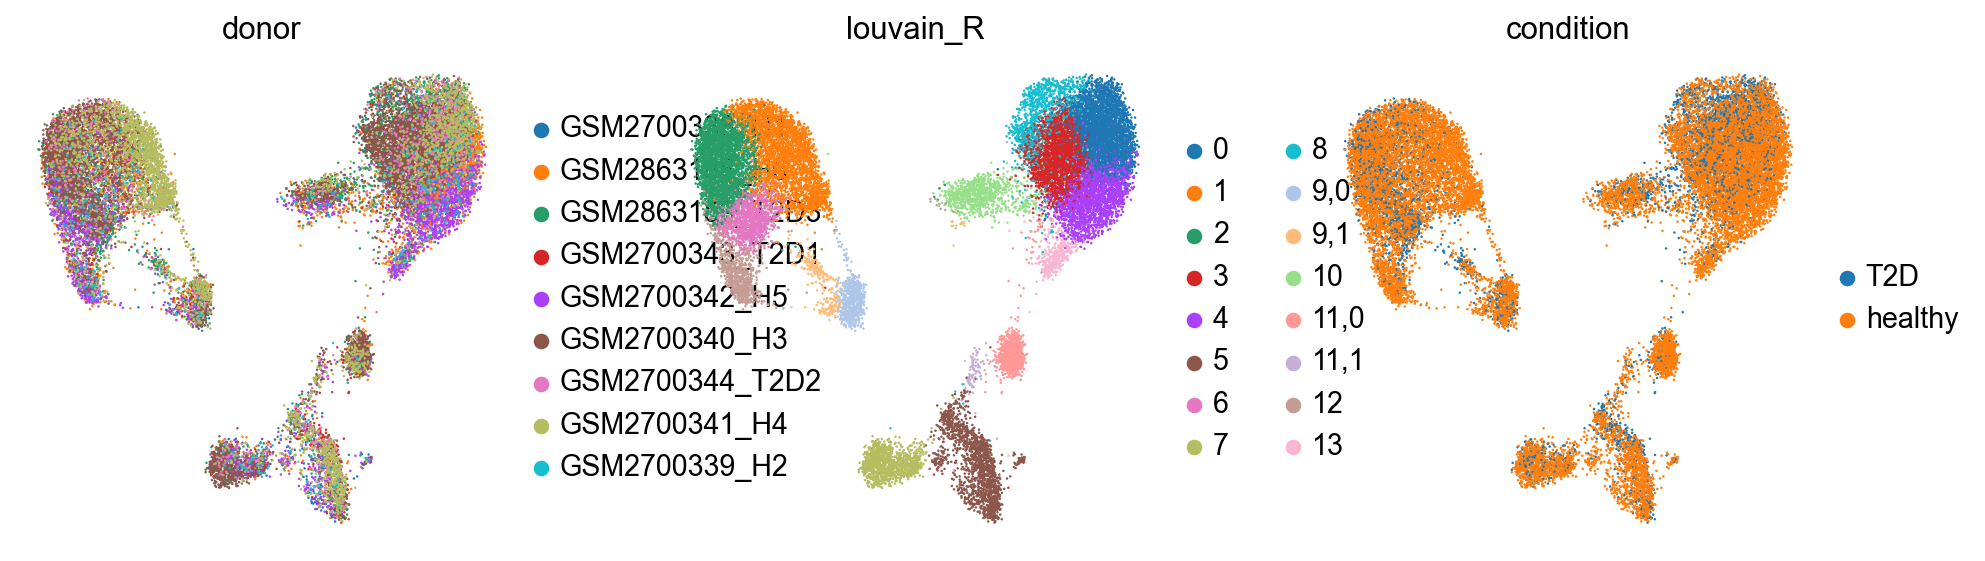

In [52]:
sc.pl.umap(fang, color=['donor', 'louvain_R', 'condition'])

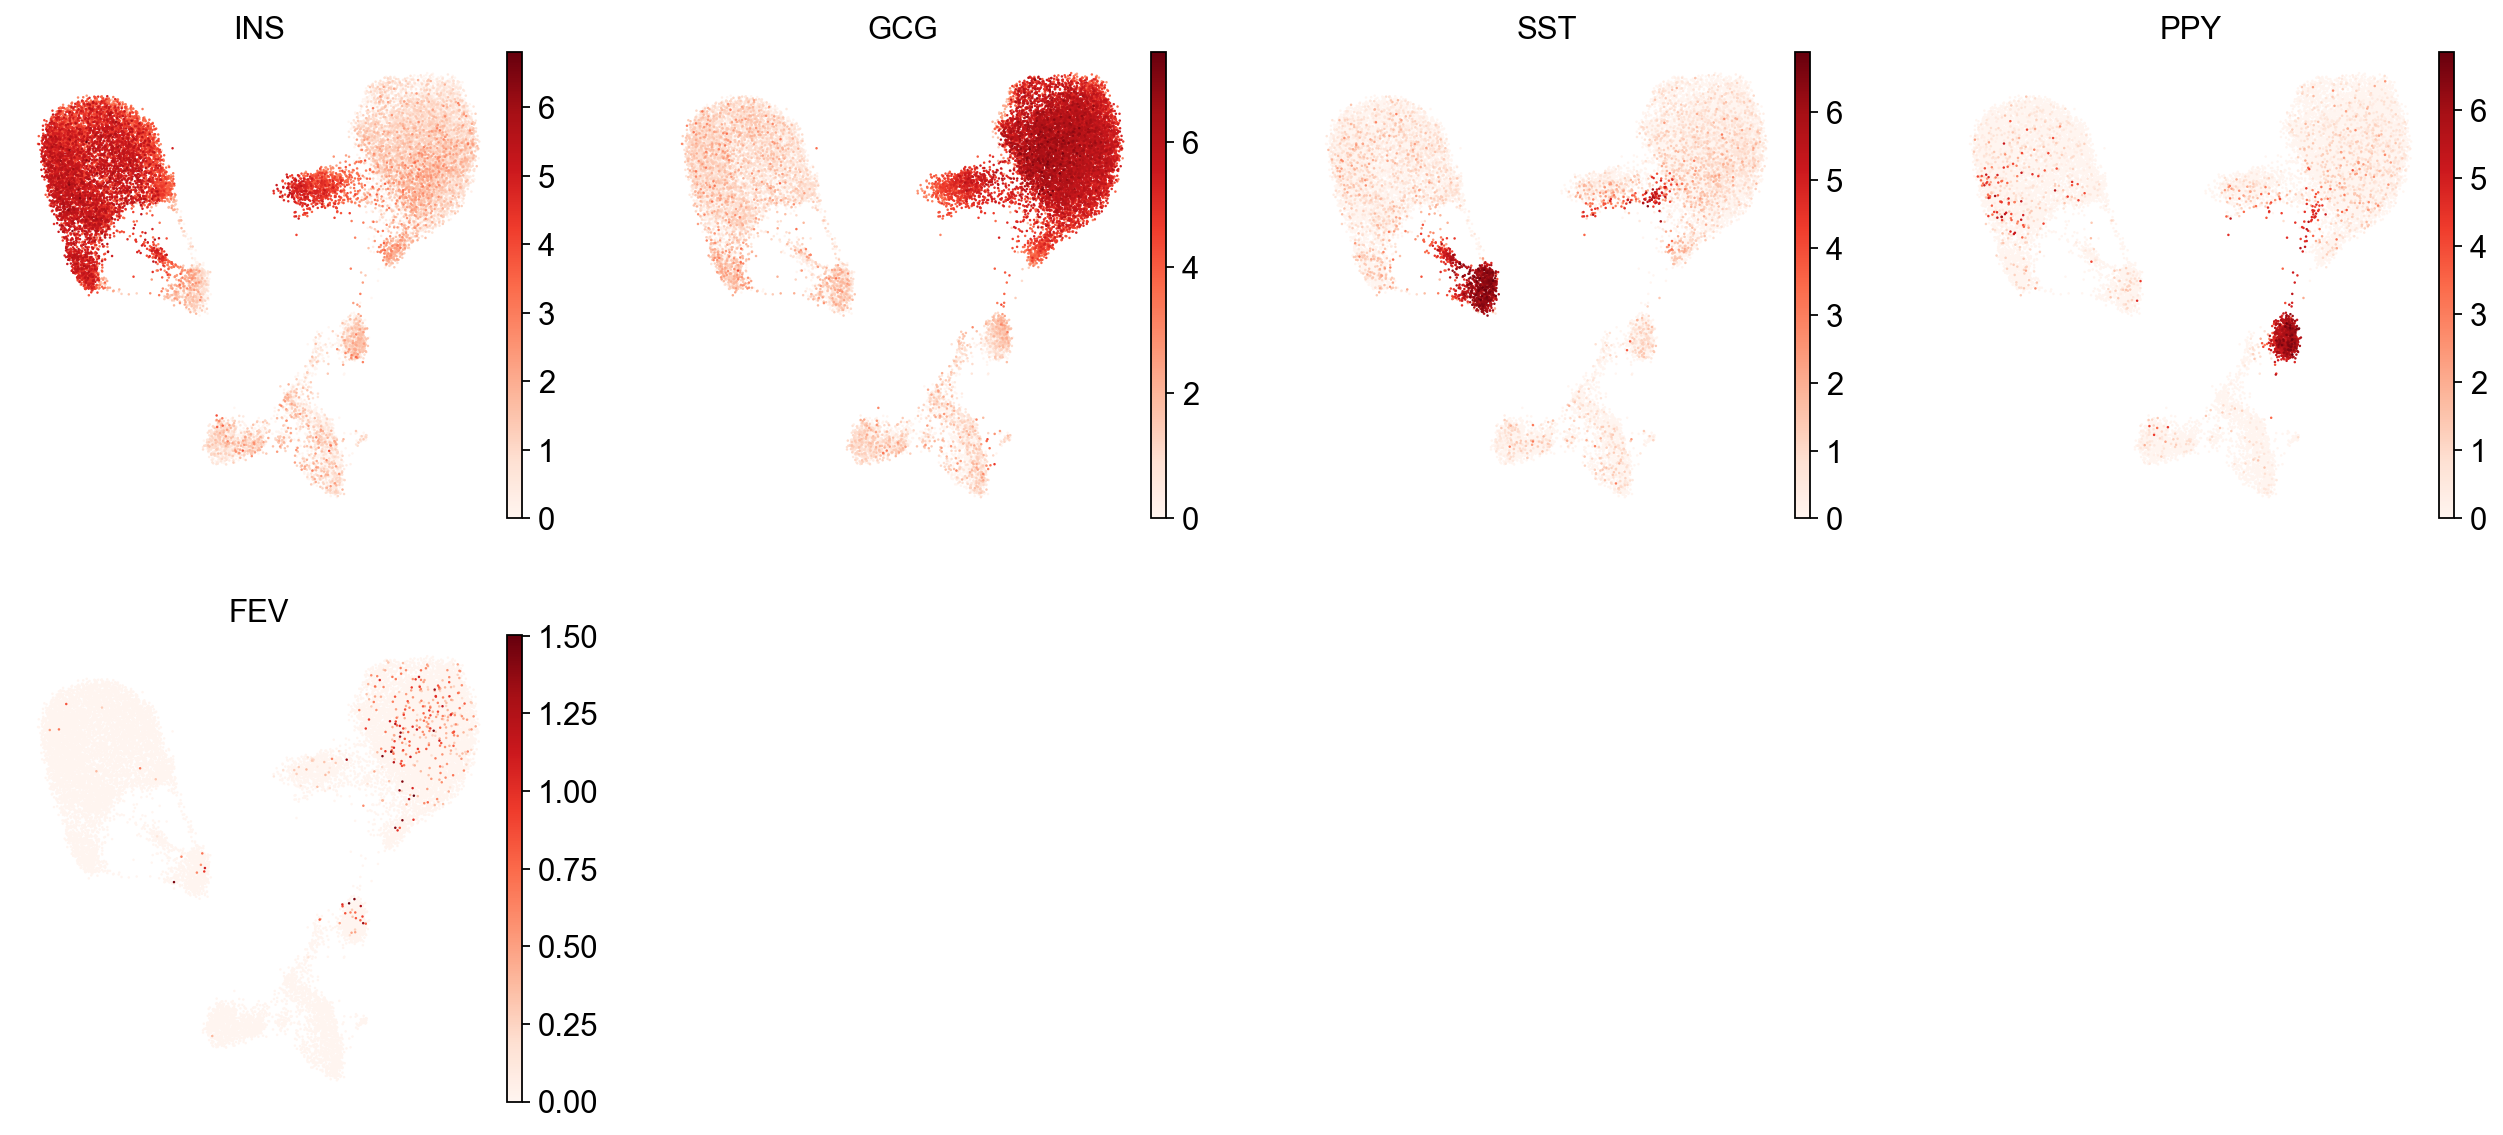

In [53]:
sc.pl.umap(fang, color=['INS', 'GCG', 'SST', 'PPY', 'FEV'])

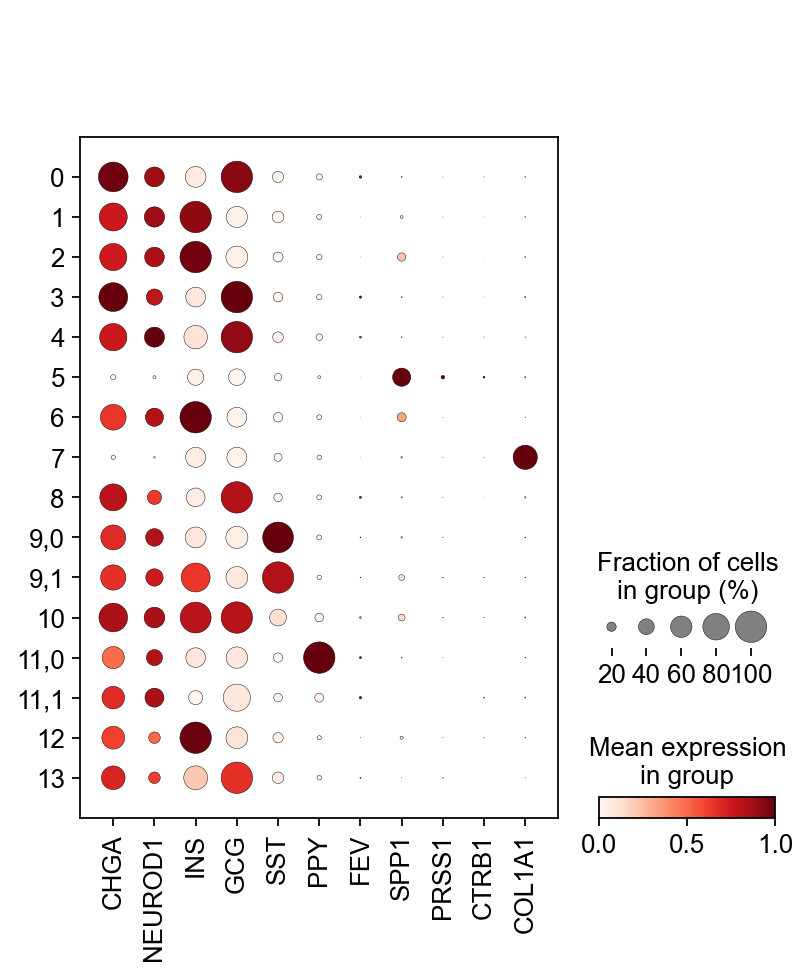

In [55]:
sc.pl.dotplot(fang, groupby='louvain_R', var_names=['CHGA', 'NEUROD1', 'INS', 'GCG', 'SST', 'PPY', 'FEV', 'SPP1', 'PRSS1', 'CTRB1', 'COL1A1'], standard_scale='var')

In [56]:
map_names = {}

for c in fang.obs['louvain_R'].cat.categories:
    if c in ['1', '6', '2', '12']:
        map_names[c] = 'beta'
    elif c in ['0', '3', '4', '8', '13']:
        map_names[c] = 'alpha'  
    elif c in ['9,0']:
        map_names[c] = 'delta'
    elif c in ['11,0']:
        map_names[c] = 'PP'   
    elif c in ['5', '11,1']:
        map_names[c] = 'ductal' 
    elif c in ['7']:
        map_names[c] = 'stellate/fibroblast'
    elif c in ['10', '9,1']:
        map_names[c] = 'polyhormonal'

    else:
        map_names[c] = c

fang.obs['louvain_anno_broad'] = fang.obs['louvain_R']
fang.obs['louvain_anno_broad'] = fang.obs['louvain_anno_broad'].map(map_names).astype('category')

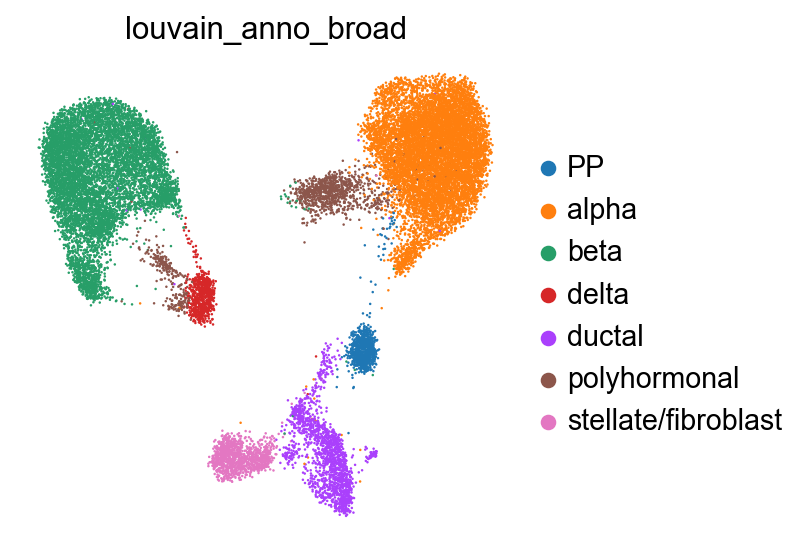

In [57]:
sc.pl.umap(fang, color=['louvain_anno_broad'])

In [98]:
fang.write('./data/fang.h5ad')

/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'donor_id' as categorical
/Users/stritschler/code/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'sex' as categorical
